## 実装リスト
- ネガポジ値算出
- ~~ワードクラウド~~
- ~~共起ネットワーク~~
    1. ~~単語組み合わせ~~
    2. ~~ネットワーク可視化~~
    3. ~~英語対応~~

In [49]:
import numpy as np
import re
import sys
import os
import time
import jaconv
import itertools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from matplotlib import pyplot as plt, font_manager
from wordcloud import WordCloud
from janome.tokenizer import Tokenizer
%matplotlib inline

font_manager._rebuild()
if os.name=='nt':
    #windows用
    font_dir=font_manager.win32FontDirectory()
else:
    #mac用
    font_dir='/Users/pydata/Library/Fonts/'
font_path=os.path.join(font_dir,'SourceHanCodeJP-Regular.otf')
font=font_manager.FontProperties(fname=font_path,size=14)

def preprocess(text,mode=0):   
    #mode==1で英語対応、mode==0で日本語対応
    if mode==1:
        words = ja_tokenize(text)
    else:
        text = text.lower()
        text = text.replace('.',' .')
        words = text.split(' ')
    
    word_to_id={}
    id_to_word={}
    for word in words:
        if word not in word_to_id:
            new_id=len(word_to_id)
            word_to_id[word]=new_id
            id_to_word[new_id]=word
    
    corpus=np.array([word_to_id[w] for w in words])
    return corpus,word_to_id,id_to_word

def create_co_matrix(corpus,vocab_size,window_size=1):
    corpus_size=len(corpus)
    co_matrix=np.zeros((vocab_size, vocab_size),dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1,window_size+1):
            left_idx=idx-i
            right_idx=idx+i
            
            if left_idx>=0:
                left_word_id=corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx<corpus_size:
                right_word_id=corpus[right_idx]
                co_matrix[word_id,right_word_id] += 1
        
    return co_matrix

def cos_similarity(x,y,eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2)+eps)
    ny = y / np.sqrt(np.sum(y**2)+eps)
    return np.dot(nx,ny)

def most_similar(query,word_to_id,id_to_word,word_matrix,top=5):
    #1 take query
    if query not in word_to_id:
        print('%s is not found' %query)
        return
    
    print('\n[query]'+query)
    query_id=word_to_id[query]
    query_vec=word_matrix[query_id]
    
    #2 cal cos similarity
    vocab_size=len(id_to_word)
    similarity=np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i]=cos_similarity(word_matrix[i],query_vec)
    
    count=0
    for i in (-1*similarity).argsort():
        if id_to_word[i] == query:
            continue
        print('%s: %s' %(id_to_word[i], similarity[i]))
        
        count+=1
        if count >= top:
            return

def ppmi(C,verbose=False,eps=1e-8):
    M=np.zeros_like(C,dtype=np.float32)
    N=np.sum(C)
    S=np.sum(C,axis=0)
    total=C.shape[0]*C.shape[1]
    cnt=0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi=np.log2(C[i,j]*N/(S[j]*S[i])+eps)
            M[i,j]=max(0,pmi)
            
            if verbose:
                cnt+=1
                if cnt % (total/100)==0:
                    print('%.1f%% done' % (100*cnt/total))
    return M        

def plotting(U,word_to_id,height=5,width=5,mode=0,filename='./output'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(height,width))
    for word, word_id in word_to_id.items():
        plt.annotate(word, (U[word_id, 0],U[word_id,1]))
    plt.scatter(U[:,0],U[:,1],alpha=0.5)
    if mode==0:
        plt.show()
    else:
        import matplotlib
        matplotlib.use('Agg')
        plt.savefig('./'+filename+'_ppmi.png')

def ja_tokenize(text):
    ja_tokenizer = Tokenizer()
    res=[]
    
    #stop word
    text=re.sub('/','',text)
    text=re.sub('セ','',text)
    text=re.sub('{}','',text)
    text=re.sub('　','',text)
    text=re.sub(' ','',text)
    text=re.sub(':','',text)
    text=re.sub("'",'',text)
    text=re.sub('.','',text)
    text=jaconv.h2z(text,digit=True, ascii=True)
    lines=text.split('\n')

    for line in lines:
        malist = ja_tokenizer.tokenize(line)
        for tok in malist:
            ps=tok.part_of_speech.split(",")[0]
            if not ps in ['名詞', '動詞', '形容詞', '形容動詞']: continue
            w=tok.base_form
            if w=="*" or w=="": w=tok.surface
            if w=="" or w=="\n": continue
            res.append(w)
        res.append("\n")
    return res

def en_tokenize(text):
    text=re.sub(',','',text)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
            
    return filtered_sentence
    
def read_file(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        text=f.read()
    text=re.sub('\n','',text)
    return text

def convert_one_hot(corpus, vocab_size):
    """
    convert to one hot vector
    :param corpus: word id list (1 dimension or 2 dimension NumPy array)
    :param vocab_size: vocabulary size
    :return: one-hot vector (2 dimension or 3 dimension NumPy array)
    """
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)

        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

def create_contexts_target(corpus,window_size=1):
    target=corpus[window_size:-window_size]
    contexts=[]
    
    for idx in range(window_size,len(corpus)-window_size):
        cs=[]
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

def keyword_check(part):
    return re.match('名詞' or '動詞' or '形容詞' or'形容動詞',part)

def text_analyze(text):
    t=Tokenizer()
    tokens=t.tokenize(text)
    result=[]
    
    for token in tokens:
        result.append([token.surface,token.part_of_speech])
    return result

def make_freq(text,encoding='utf-8'):
    word_dic={}
    analyze_list=text_analyze(text)
    
    for word, part in analyze_list:
        if(keyword_check(part)):
            if word in word_dic:
                word_dic[word]+=1
            else:
                word_dic[word]=1
                
    return(word_dic)

def display(word_dic,width=10,height=10,top=10,filename='disp_output',mode=1):
    key,value=zip(*word_dic.most_common(top))
    plt.figure(figsize=(height,width))
    plt.bar(key,value,color='orange')
    plt.xticks(rotation=90)
    if mode==0:
        plt.show()
    elif mode==1:
        import matplotlib
        matplotlib.use('Agg')
        plt.savefig(filename+'_d'+'.png')
    else:
        print('unsaved')
    
def word_cloud(text,bg_color="white",width=800,height=450,filename='wordcloud',mode=0):
    #文字列除去
    text=str(text)
    text=re.sub('/\r\n/g','',text)
    text=re.sub("'",'',text)
    
    stop_words = [u'＇',u"'",u'てる', u'いる', u'なる', u'れる', u'する', u'ある', u'こと', u'これ', u'さん', u'して',u'くれる', u'やる', u'くださる', u'そう', u'せる', u'した',  u'思う',u'それ', u'ここ', u'ちゃん', u'くん', u'', u'て',u'に',u'を',u'は',u'の', u'が', u'と', u'た', u'し', u'で',u'ない', u'も', u'な', u'い', u'か', u'ので', u'よう', u'',u'/\r?\n/g']
    wordcloud=WordCloud(background_color=bg_color,font_path="C:\Windows\Fonts\Yu Gothic UI\YuGothM.ttc",width=width,height=height,stopwords=set(stop_words)).generate(text)
    
    if mode==0:
        plt.figure(figsize=(15,12))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    else:
        wordcloud.to_file('./'+filename+'_wc'+'.png')

def comb_words(text,mode=0):
    import pandas as pd
    
    if mode == 0:
        sentences=[ja_tokenize(word) for word in text.split('\n')]
    elif mode == 1:
        sentences=[en_tokenaize(word) for word in text.split('.')]
    sentence_combinations=[list(itertools.combinations(sentence,2)) for sentence in sentences]
    sentence_combinations=[[tuple(sorted(words)) for words in sentence] for sentence in sentence_combinations]
    target_combinations=[]
    
    for sentence in sentence_combinations:
        target_combinations.extend(sentence)
    
    count=Counter(target_combinations)
    pd.DataFrame([{'first':i[0][0],'second':i[0][1],'count':i[1]} for i in count.most_common()]).to_csv('kyoki.csv',index=False)
    
def word_network(tagname='output'):
    from pyvis.network import Network
    import pandas as pd
    
    got_net=Network(height="1000px", width="95%",bgcolor="#FFFFFF",font_color="black",notebook=True)
#     got_net.barnes_hut()
    got_net.force_atlas_2based()
    got_data=pd.read_csv("kyoki.csv")[:150]
    
    sources=got_data['first']#count
    targets=got_data['second']#first
    weights=got_data['count']#second
    
    edge_data=zip(sources, targets, weights)
    
    for e in edge_data:
        src=e[0]
        dst=e[1]
        w=e[2]
        
        got_net.add_node(src,src,title=src)
        got_net.add_node(dst,dst,title=dst)
        got_net.add_edge(src,dst,value=w)
    
    neighbor_map=got_net.get_adj_list()
    
    for node in got_net.nodes:
        node["title"]+="Neighbors:<br>"+"<br>".join(neighbor_map[node['id']])
        node["value"]=len(neighbor_map[node['id']])
    
    got_net.show_buttons(filter_=['physics'])
    got_net.show(tagname+'_wn.html')

def simirality_list(querys,word_to_id,id_to_word,word_vecs,top=5):
    for query in querys:
        most_similar(query,word_to_id,id_to_word,word_vecs,top)    

def distribution(text,query=['sample'],window_size=2,wordvec_size=100,mode=1,filename='./output_ppmi'):
    corpus,word_to_id,id_to_word=preprocess(text,mode)
    print('elapsed time preprocess point: ',time.time()-start)
    vocab_size=len(word_to_id)
    print('counting co-occurrence...')
    C=create_co_matrix(corpus,vocab_size,window_size)
    print('elapsed time create co-matrix point: ',time.time()-start)
    print('caliculating PPMI...')
    W=ppmi(C,verbose=True)
    print('elapsed time point PPMI: ',time.time()-start)
    print('calizulating SVD...')
    
    try:
        from sklearn.utils.extmath import randomized_svd
        U,S,V=randomized_svd(W,n_components=wordvec_size,n_iter=5,random_state=None)
    except ImportError:
        U,S,V=np.linalg.svd(W)
    print('elapsed time point SVD: ',time.time()-start)
    word_vecs=U[:,:wordvec_size]

#     simirality_list(query,word_to_id,id_to_word,word_vecs)
    plotting(U,word_to_id,20,20,mode,filename)
    print('total elapsed time: ',time.time()-start)
    

elapsed time preprocess point:  2.9776928424835205
counting co-occurrence...
elapsed time create co-matrix point:  2.9776928424835205
caliculating PPMI...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% d

elapsed time preprocess point:  82.94042778015137
counting co-occurrence...
elapsed time create co-matrix point:  82.94042778015137
caliculating PPMI...
elapsed time point PPMI:  83.01851963996887
calizulating SVD...
elapsed time point SVD:  83.03414607048035
total elapsed time:  83.62532830238342
finished: CiRCLING.txt
elapsed time preprocess point:  86.42440128326416
counting co-occurrence...
elapsed time create co-matrix point:  86.42440128326416
caliculating PPMI...
elapsed time point PPMI:  86.47127056121826
calizulating SVD...
elapsed time point SVD:  86.47127056121826
total elapsed time:  86.84005451202393
finished: Dreamers Go!.txt
elapsed time preprocess point:  89.69350671768188
counting co-occurrence...
elapsed time create co-matrix point:  89.69350671768188
caliculating PPMI...
elapsed time point PPMI:  89.75599694252014
calizulating SVD...
elapsed time point SVD:  89.75599694252014
total elapsed time:  90.20497345924377
finished: Happy Happy Party!.txt
elapsed time preproc

total elapsed time:  160.75357174873352
finished: 切ないSandglass.txt
elapsed time preprocess point:  163.45215272903442
counting co-occurrence...
elapsed time create co-matrix point:  163.45515155792236
caliculating PPMI...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% 

total elapsed time:  242.92390823364258
finished: わちゃ・もちゃ・ぺったん行進曲.txt
elapsed time preprocess point:  247.97131419181824
counting co-occurrence...
elapsed time create co-matrix point:  247.98695468902588
caliculating PPMI...
elapsed time point PPMI:  248.0338258743286
calizulating SVD...
elapsed time point SVD:  248.0338258743286
total elapsed time:  248.41470074653625
finished: キミがいなくちゃっ!.txt
elapsed time preprocess point:  251.92076563835144
counting co-occurrence...
elapsed time create co-matrix point:  251.9237630367279
caliculating PPMI...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% d

elapsed time preprocess point:  305.9312765598297
counting co-occurrence...
elapsed time create co-matrix point:  305.9352924823761
caliculating PPMI...
elapsed time point PPMI:  305.9932587146759
calizulating SVD...
elapsed time point SVD:  306.00123500823975
total elapsed time:  306.4310040473938
finished: Invincible Fighter.txt
elapsed time preprocess point:  309.7101137638092
counting co-occurrence...
elapsed time create co-matrix point:  309.7141110897064
caliculating PPMI...
elapsed time point PPMI:  309.77707386016846
calizulating SVD...
elapsed time point SVD:  309.78806734085083
total elapsed time:  310.2188210487366
finished: R・I・O・T.txt
elapsed time preprocess point:  313.06119441986084
counting co-occurrence...
elapsed time create co-matrix point:  313.06419253349304
caliculating PPMI...
elapsed time point PPMI:  313.09317541122437
calizulating SVD...
elapsed time point SVD:  313.1001727581024
total elapsed time:  313.46497988700867
finished: Takin' my Heart.txt
elapsed tim

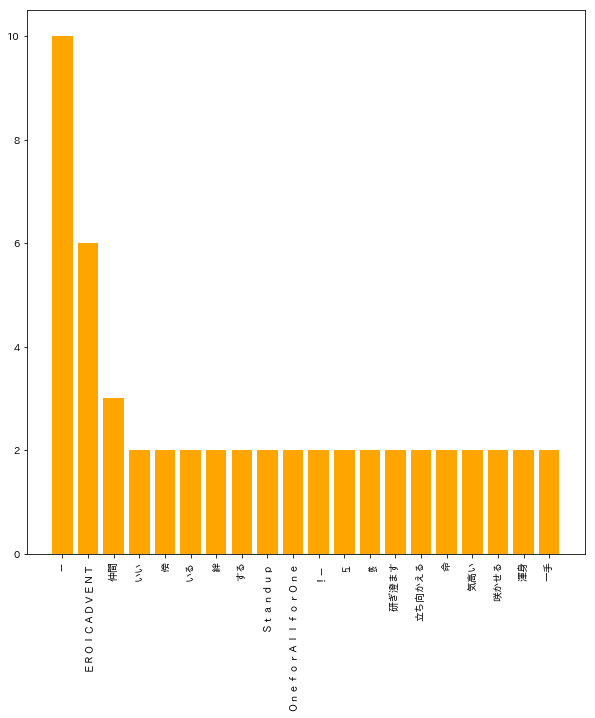

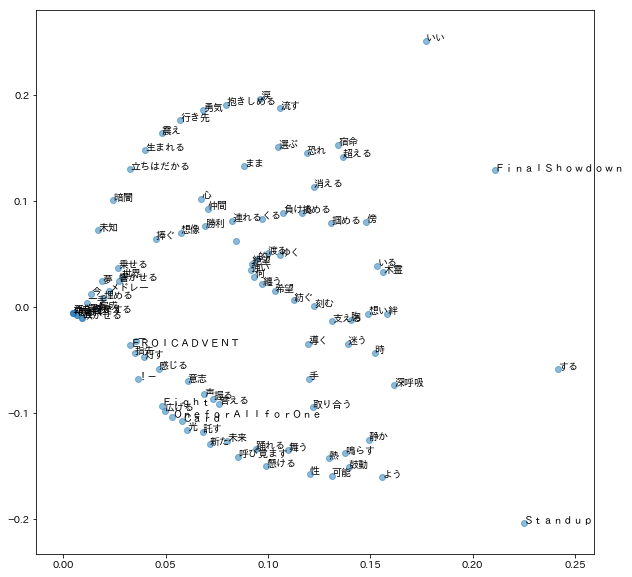

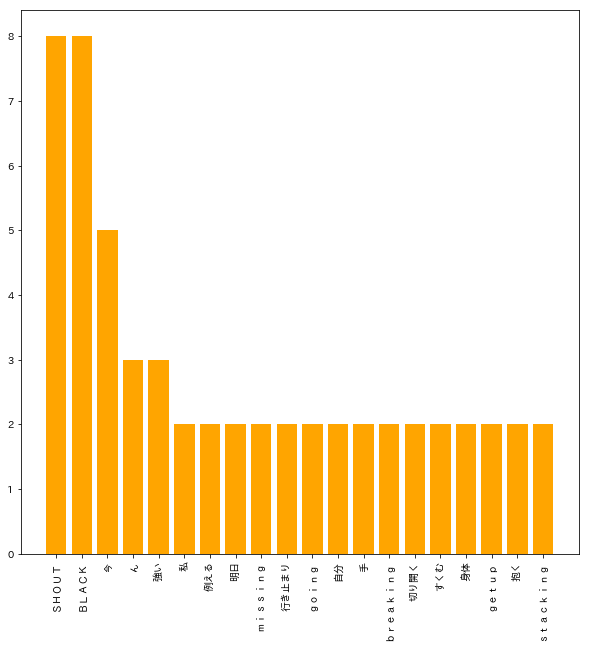

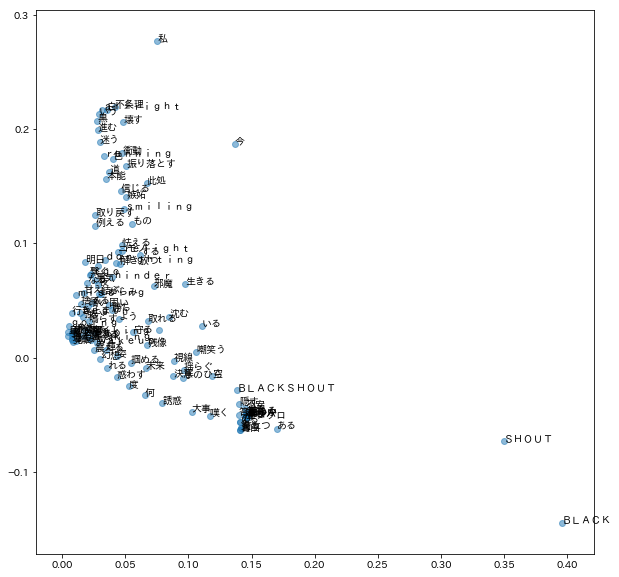

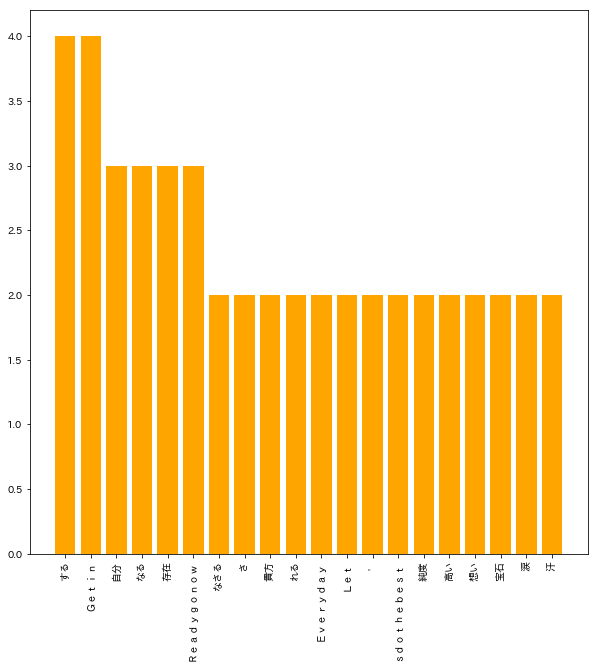

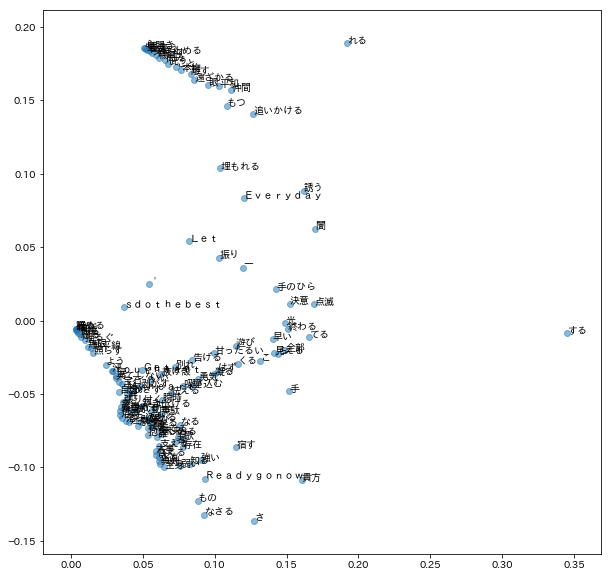

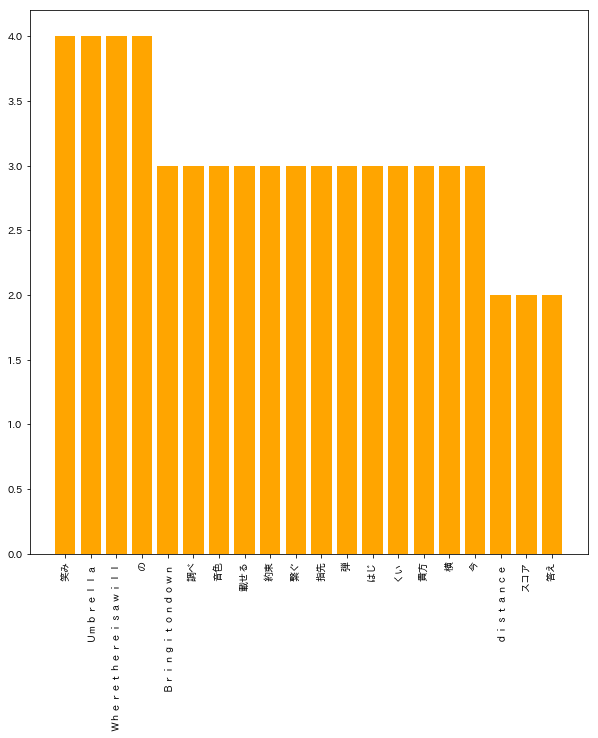

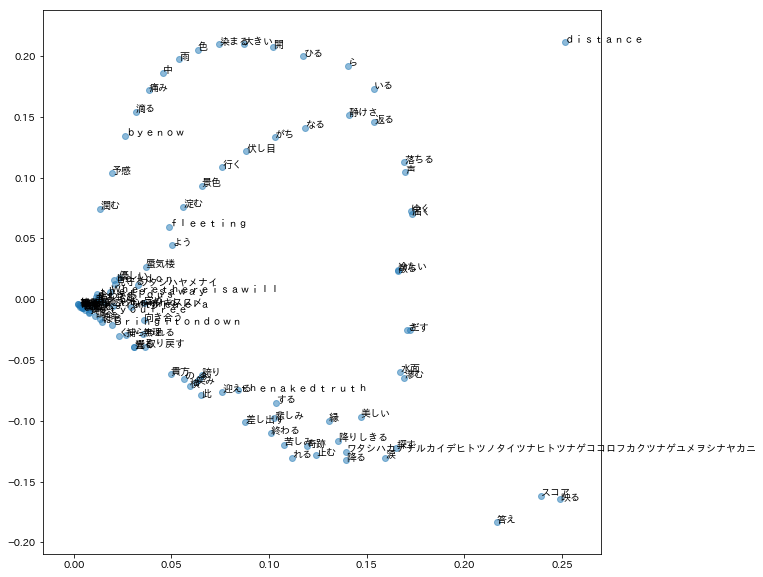

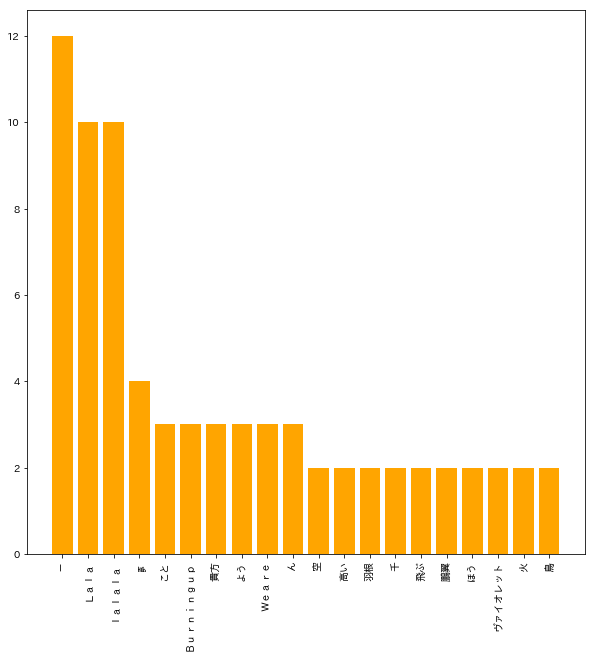

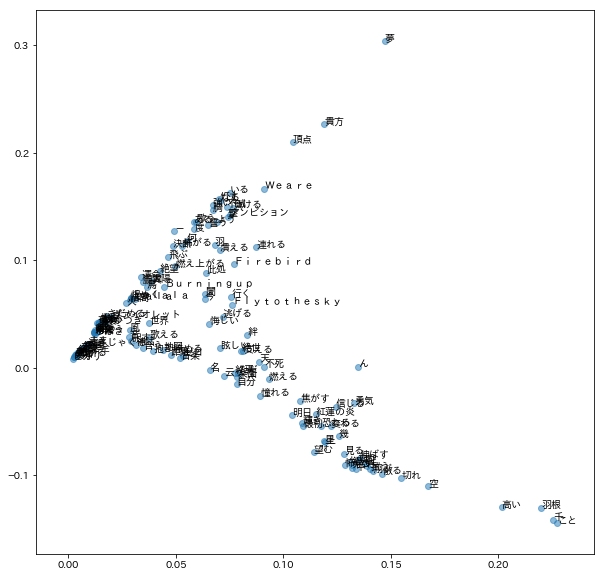

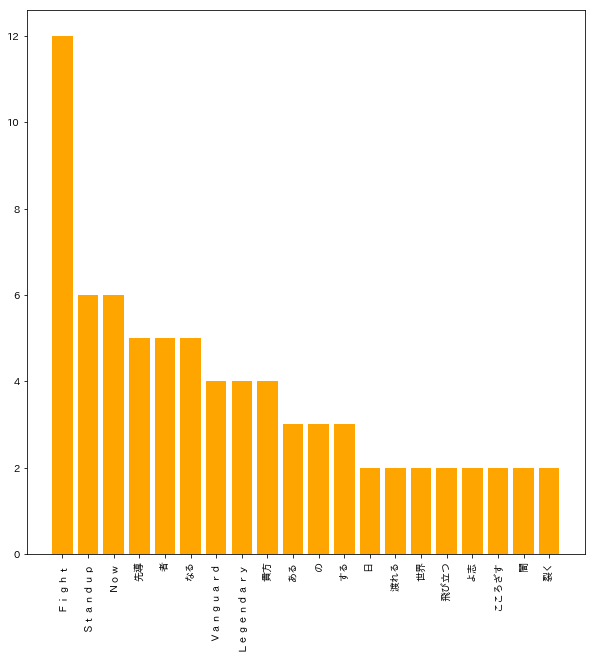

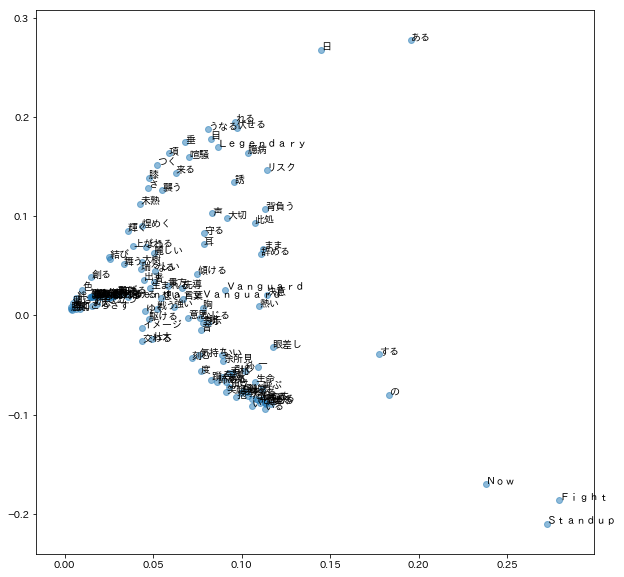

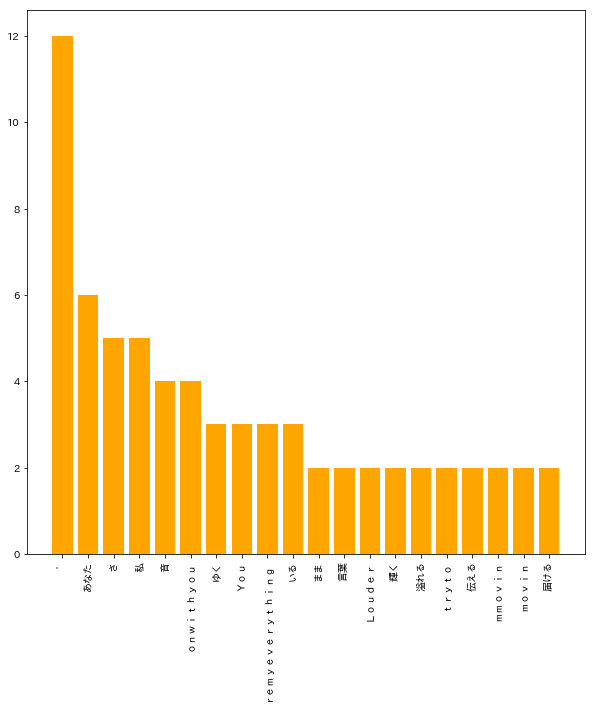

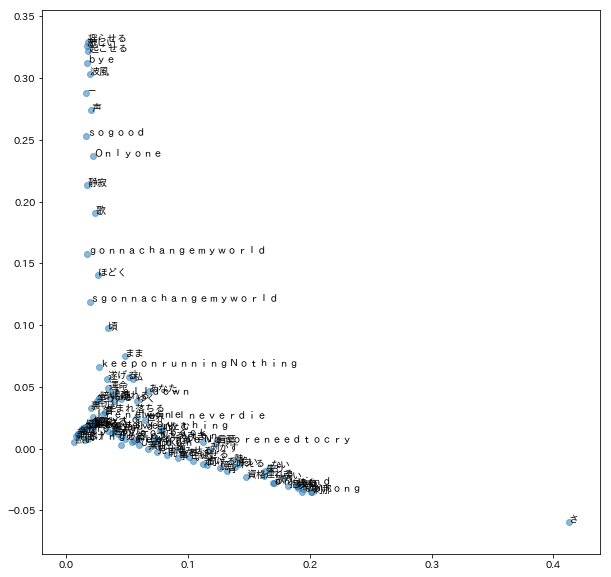

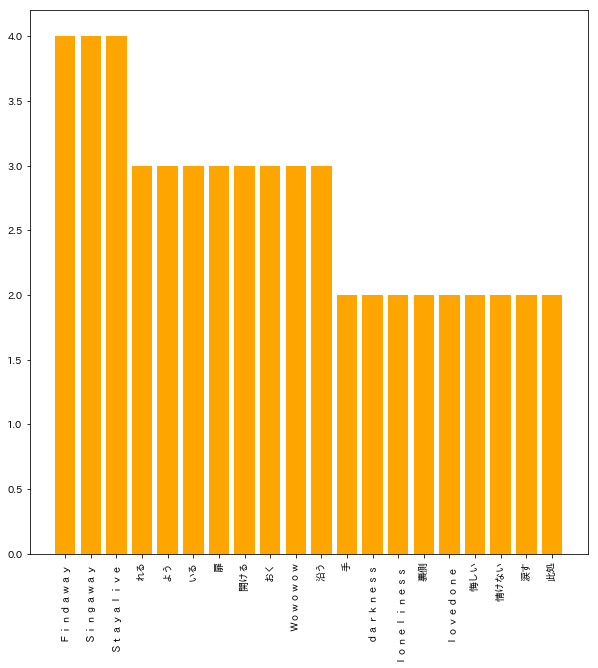

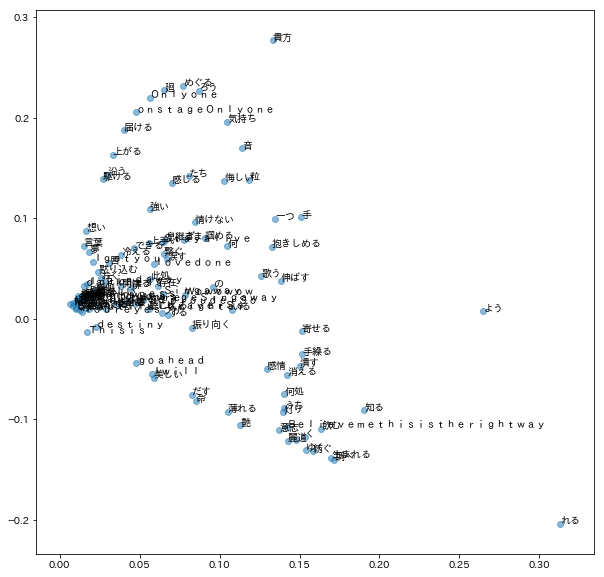

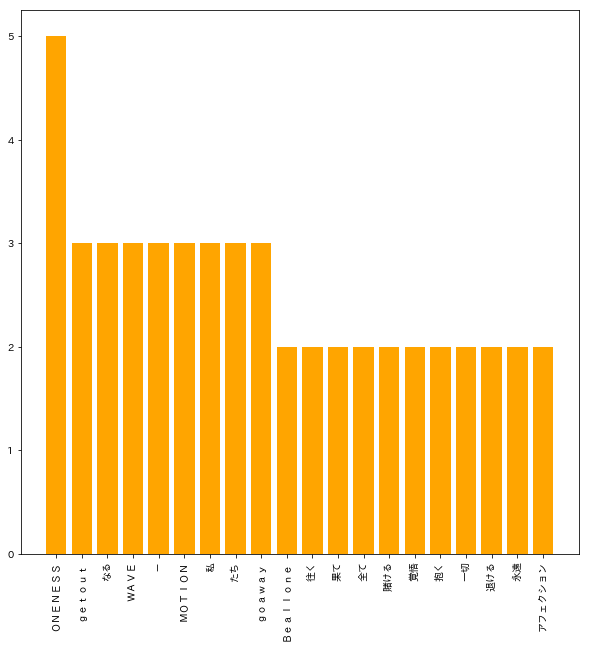

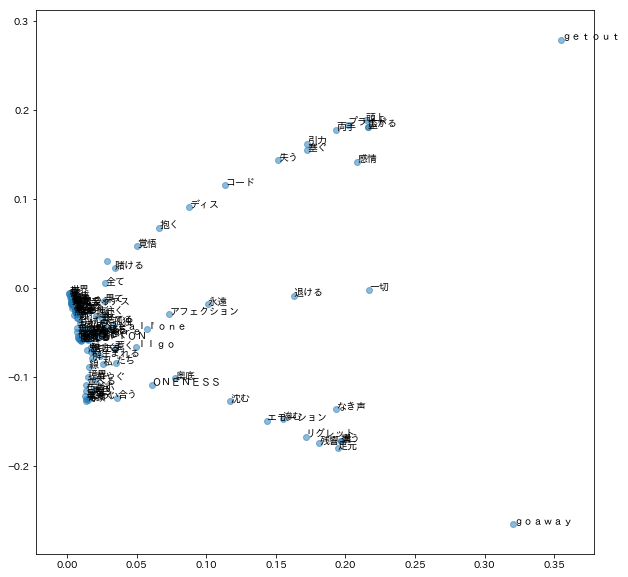

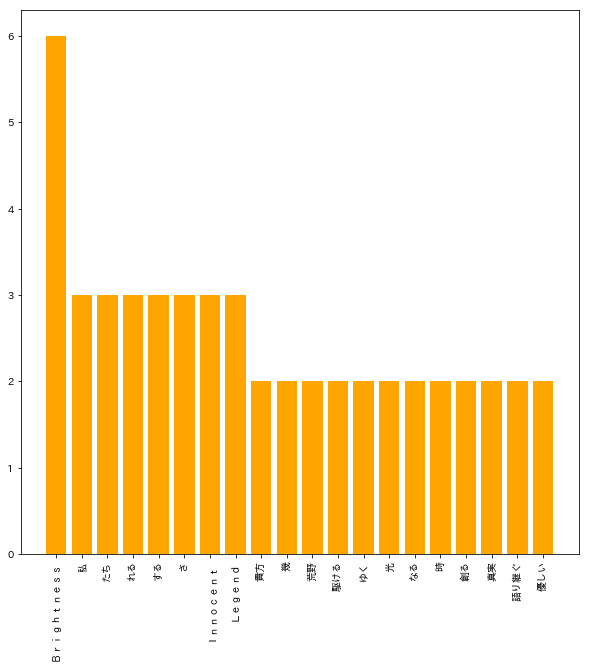

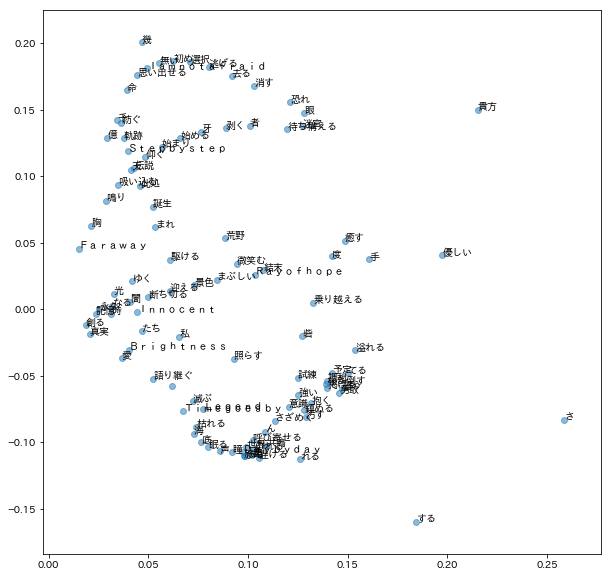

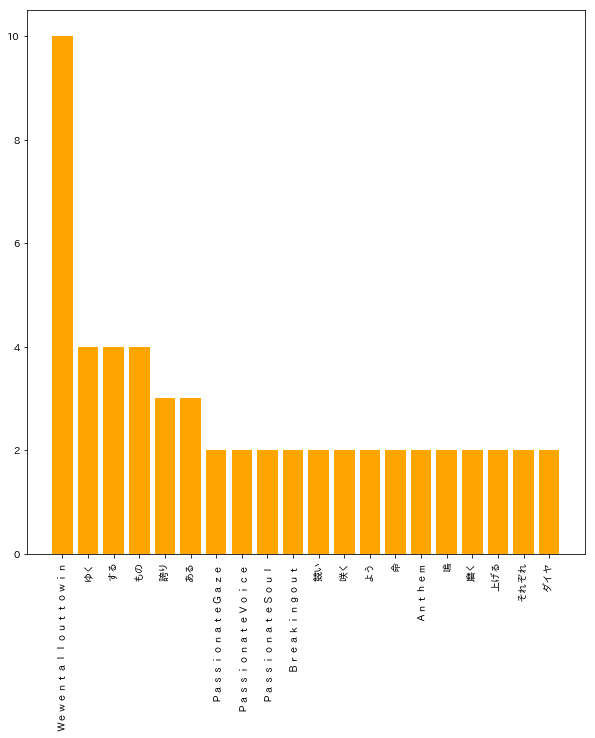

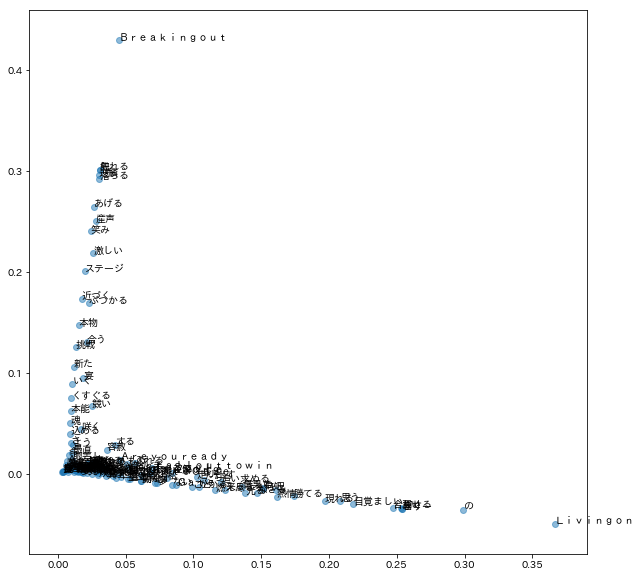

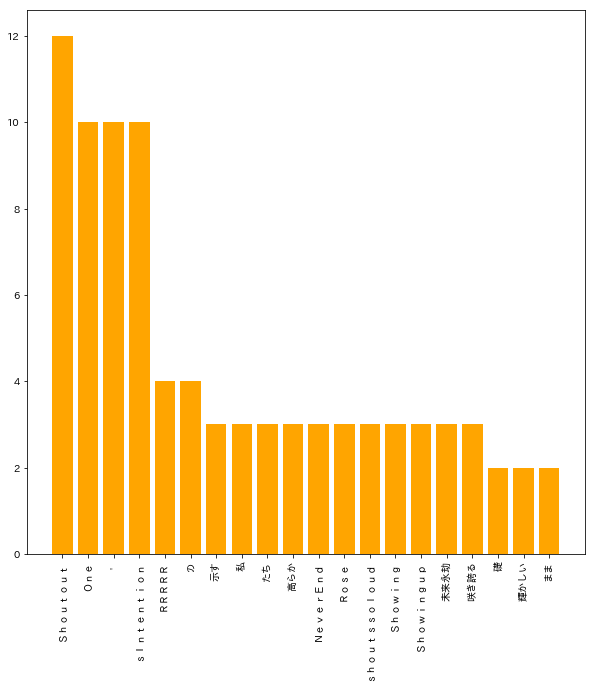

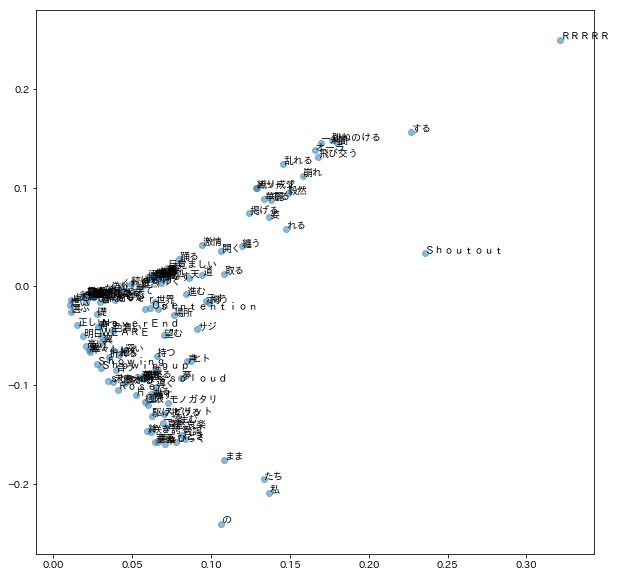

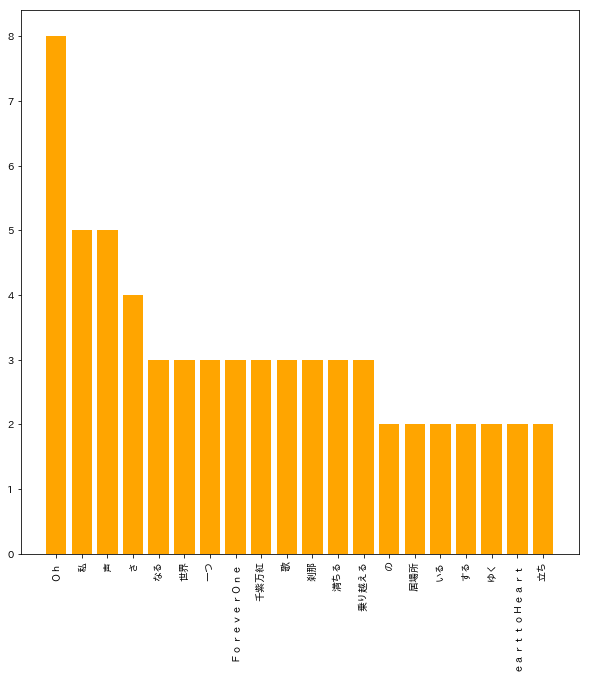

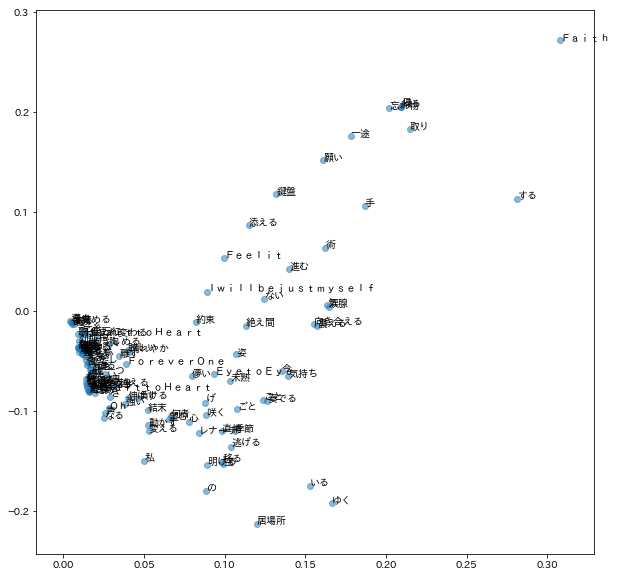

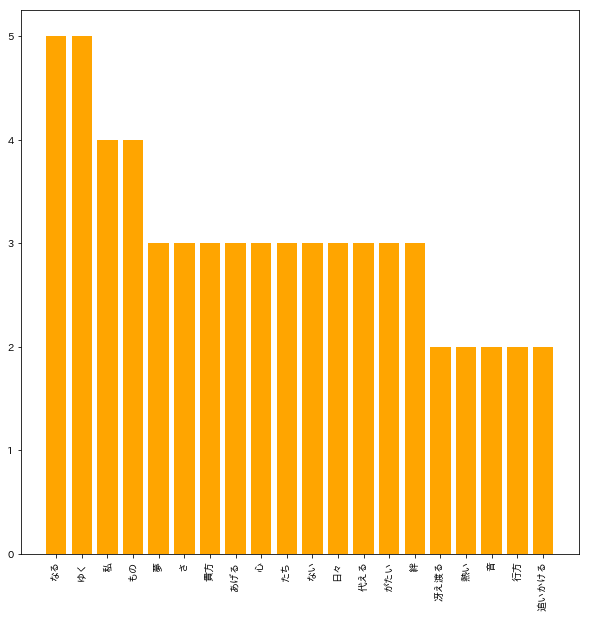

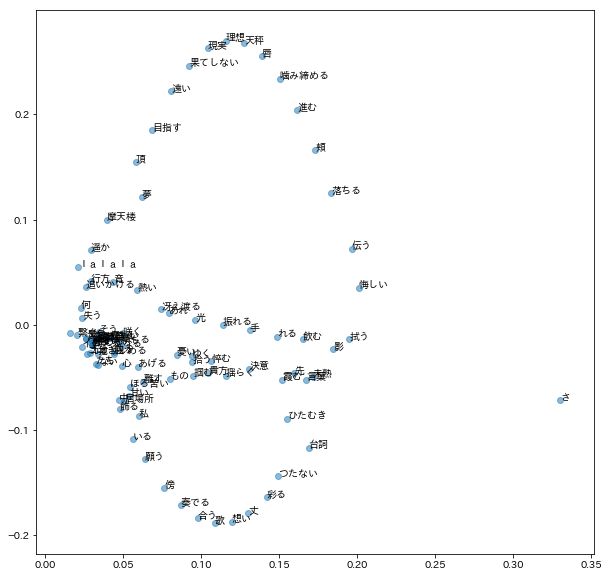

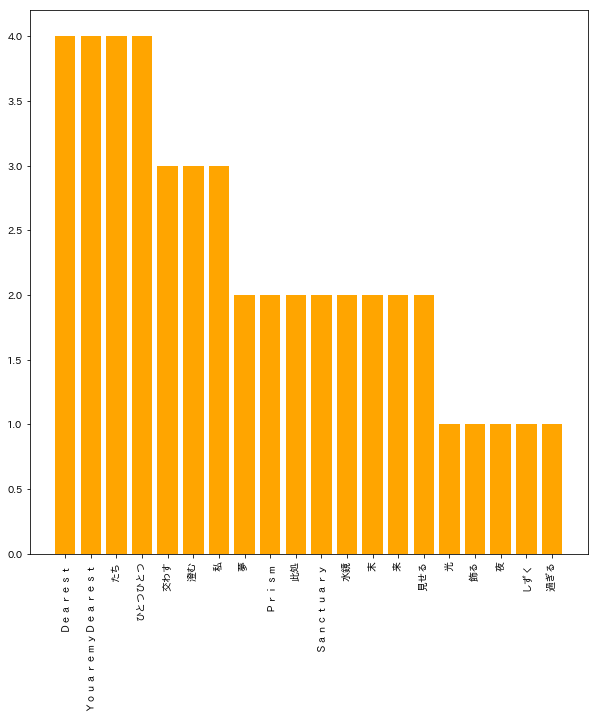

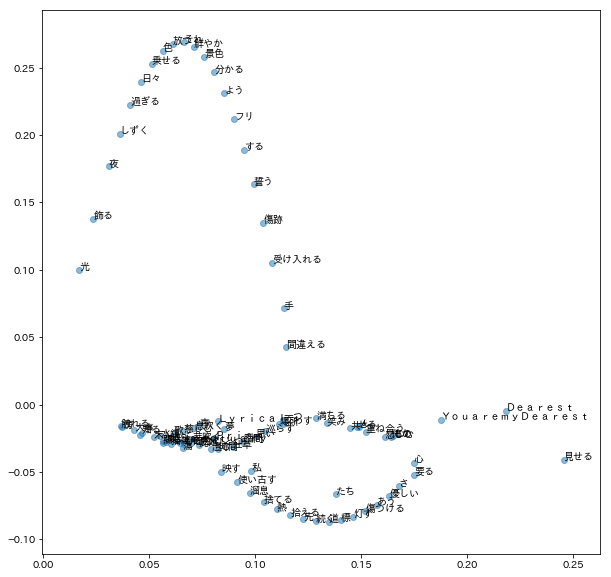

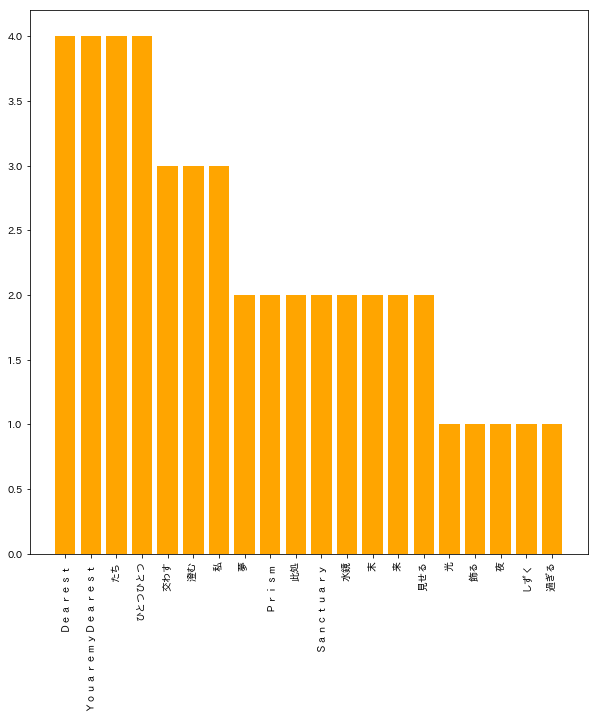

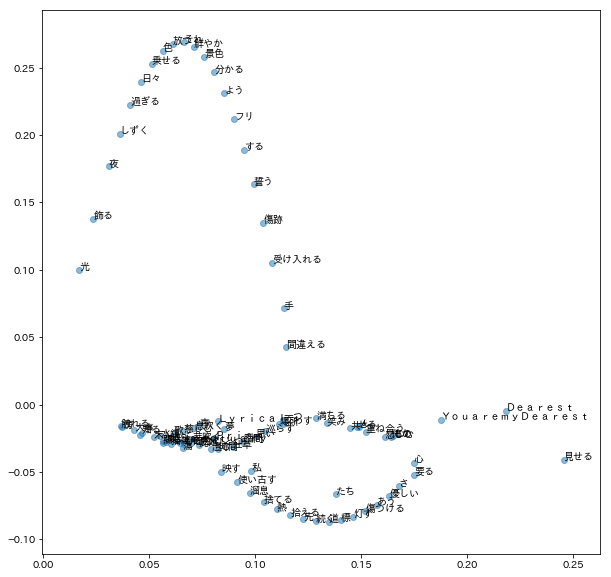

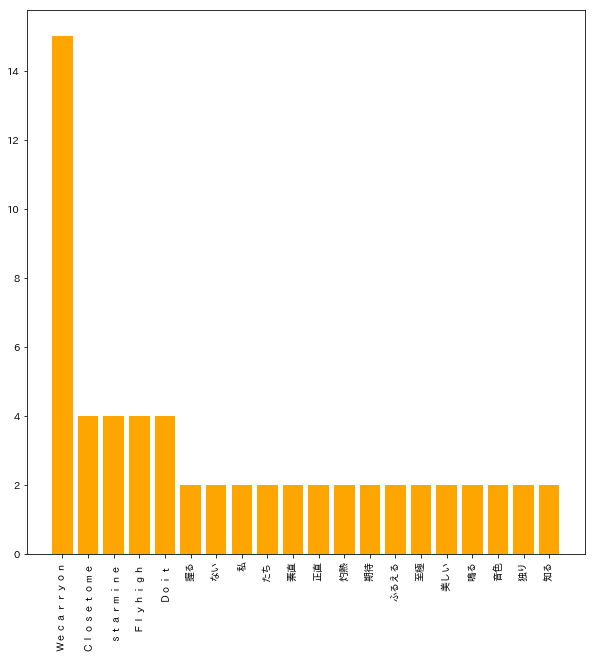

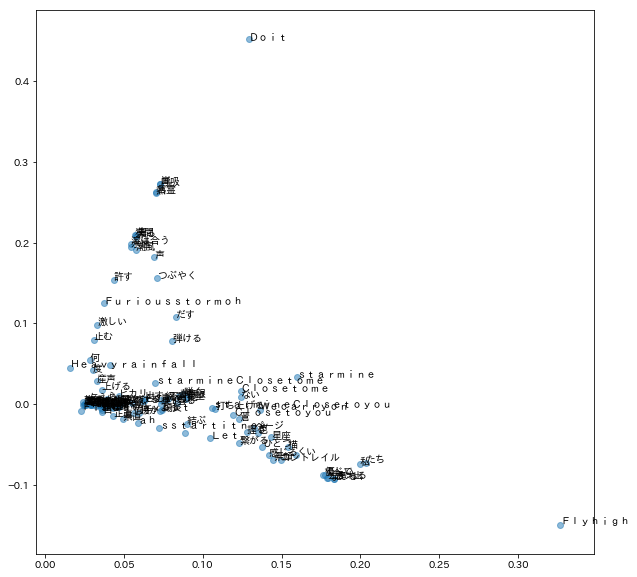

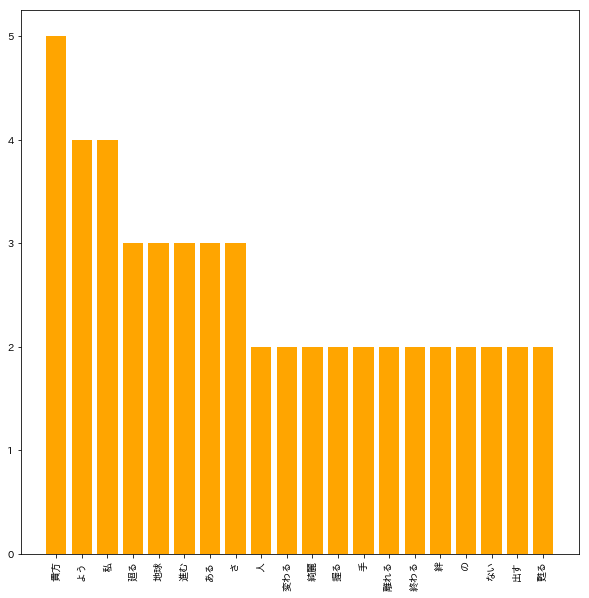

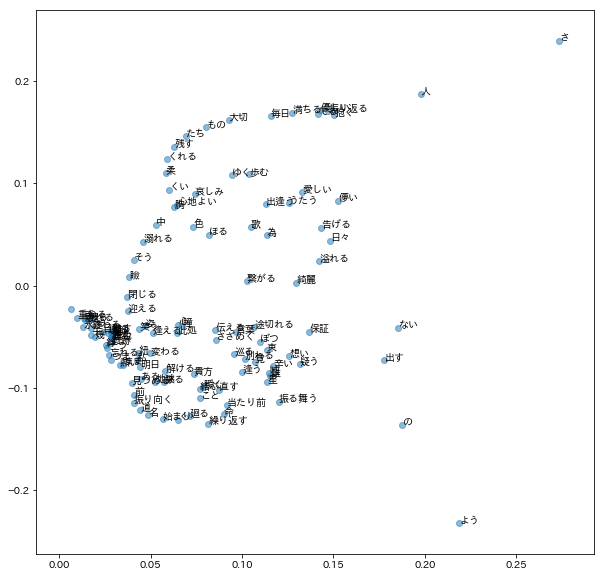

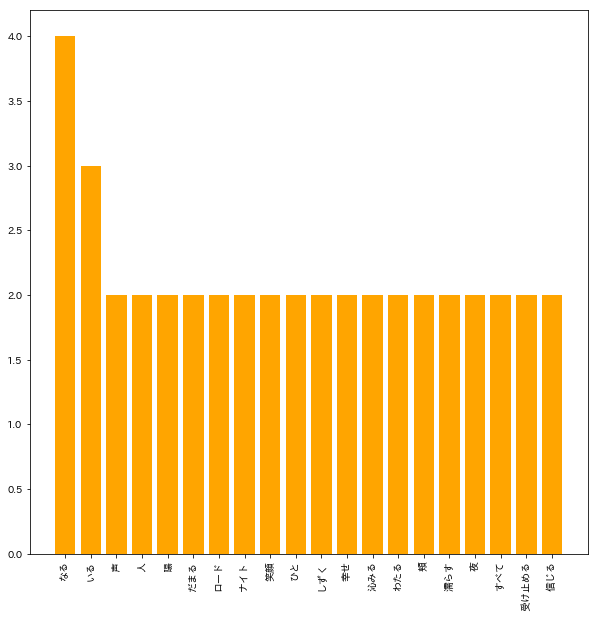

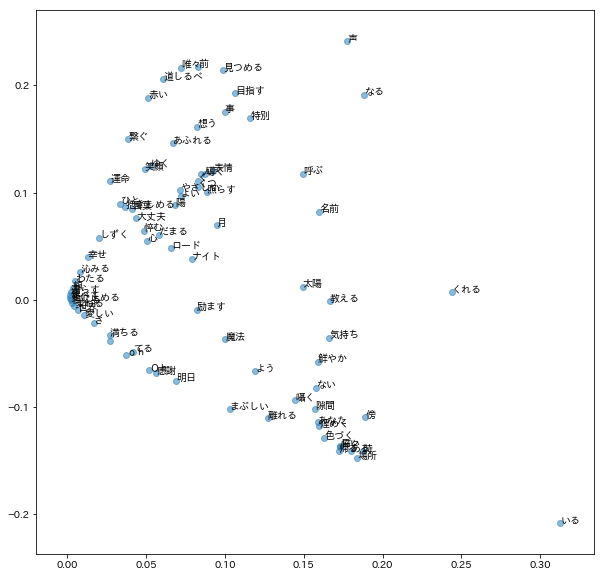

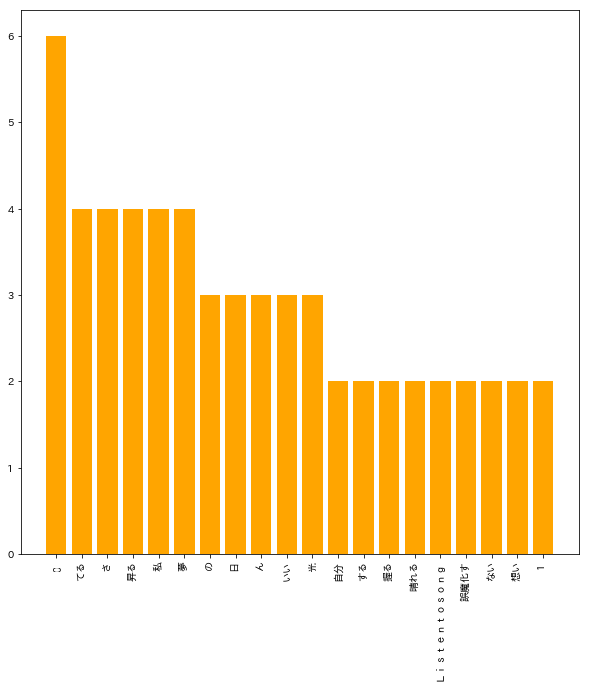

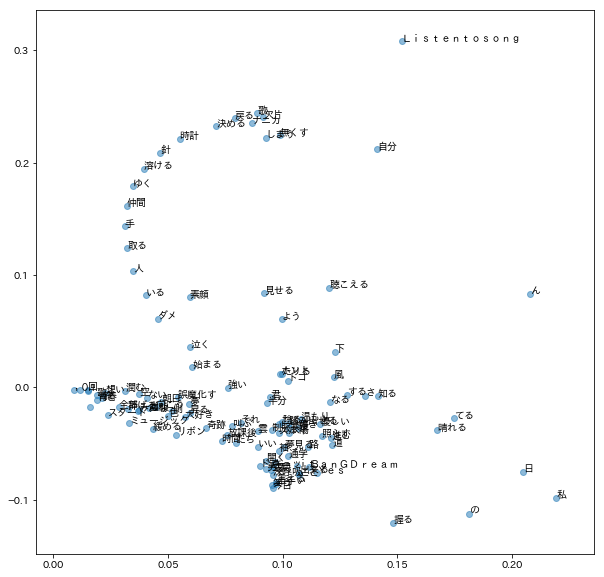

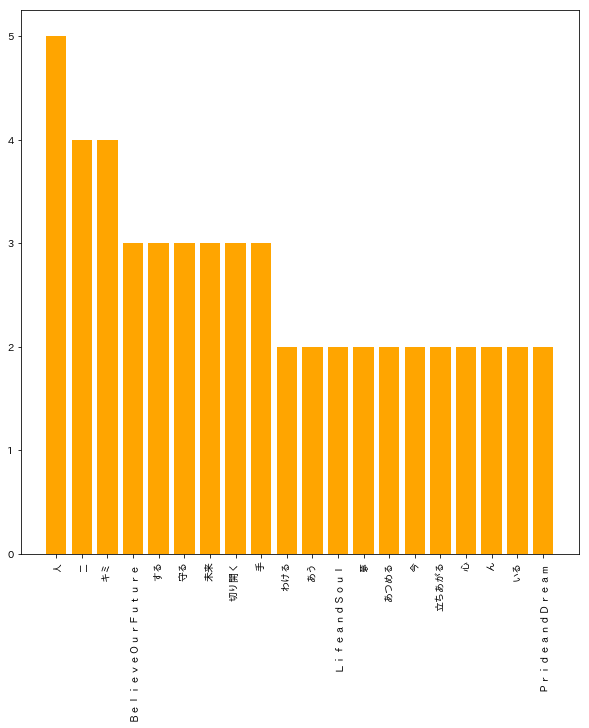

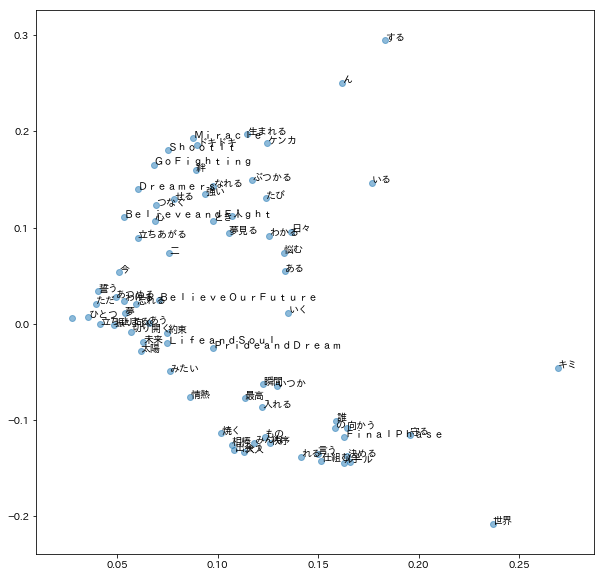

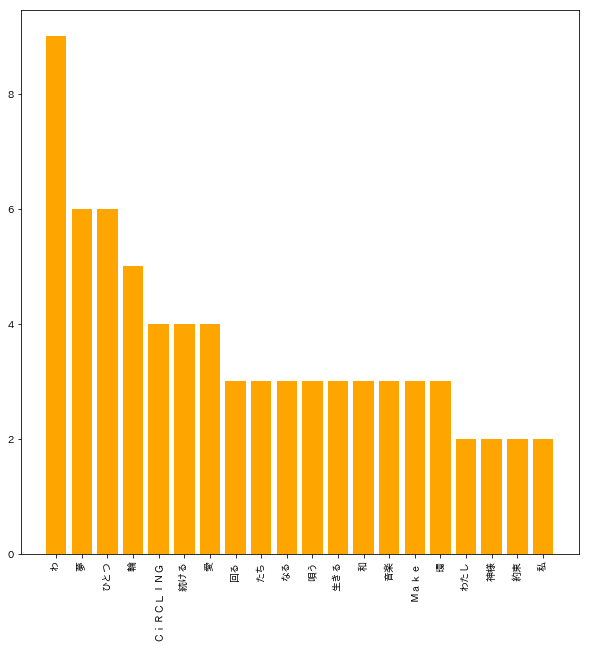

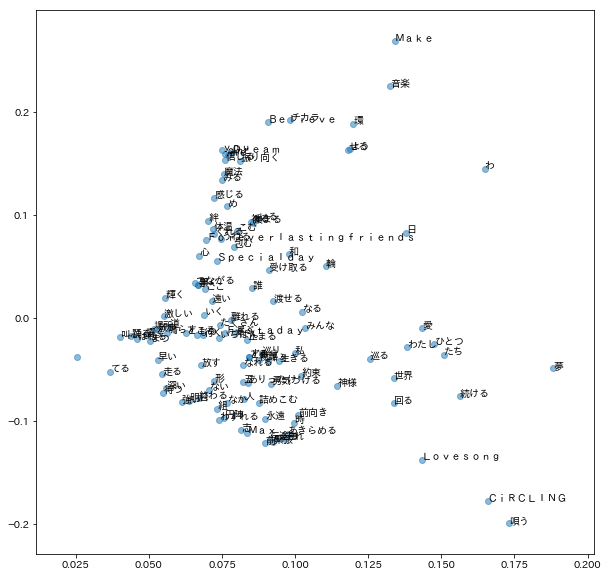

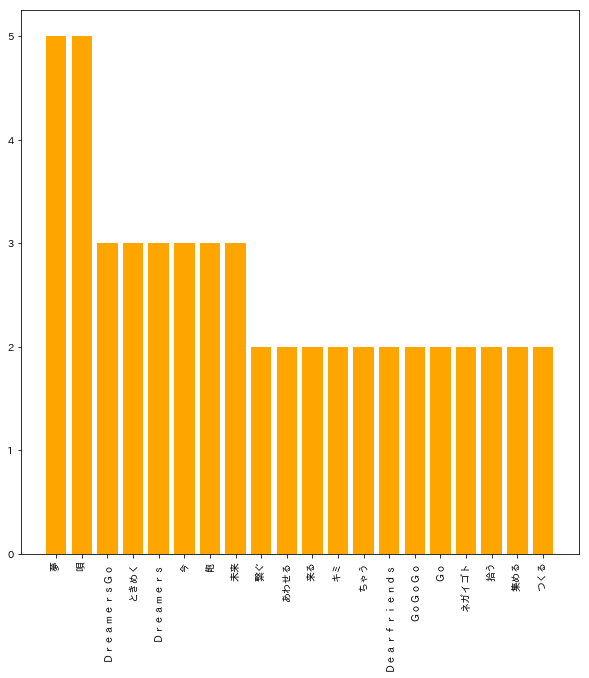

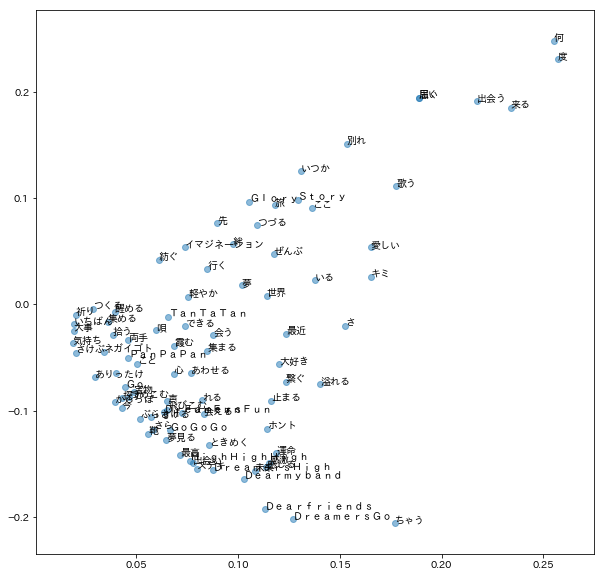

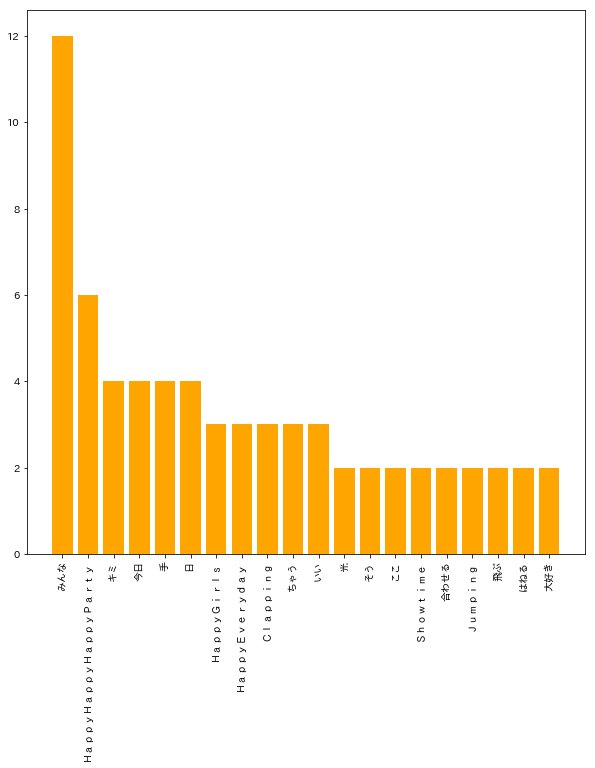

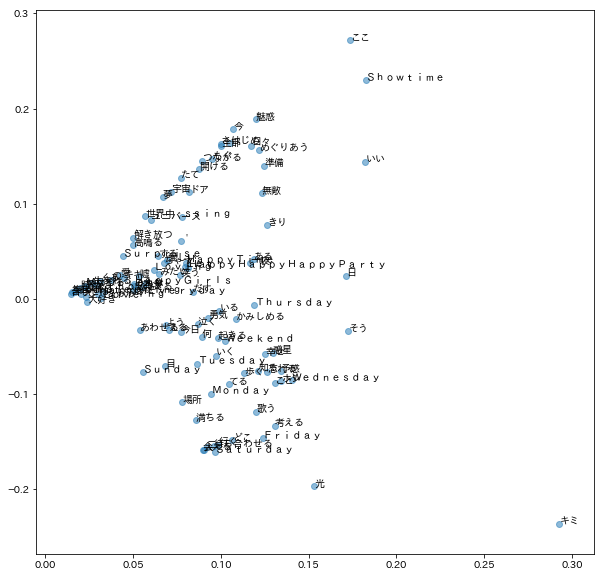

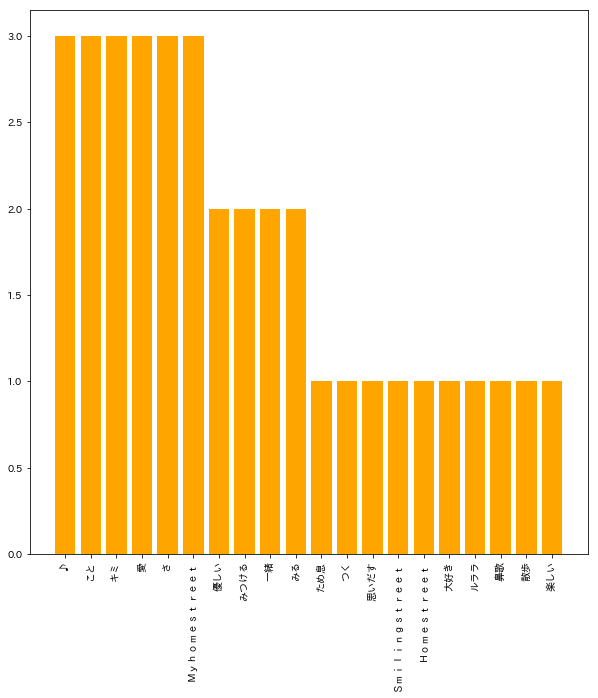

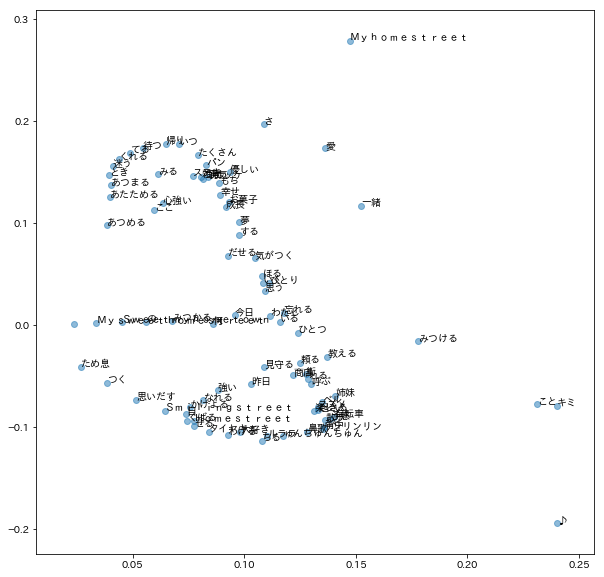

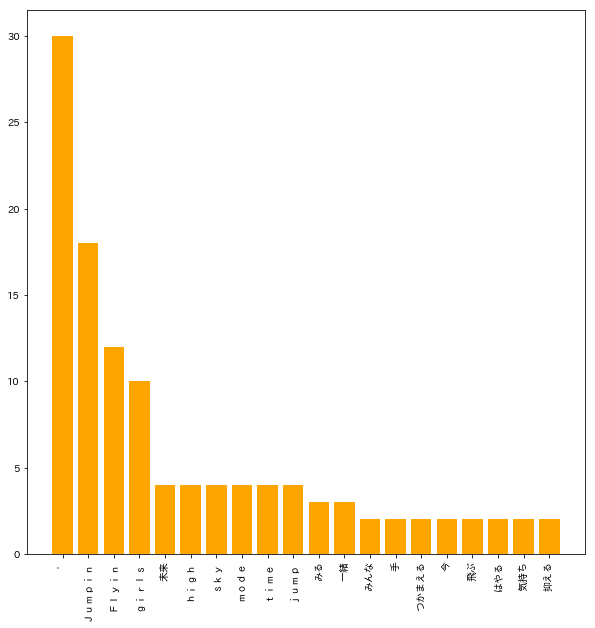

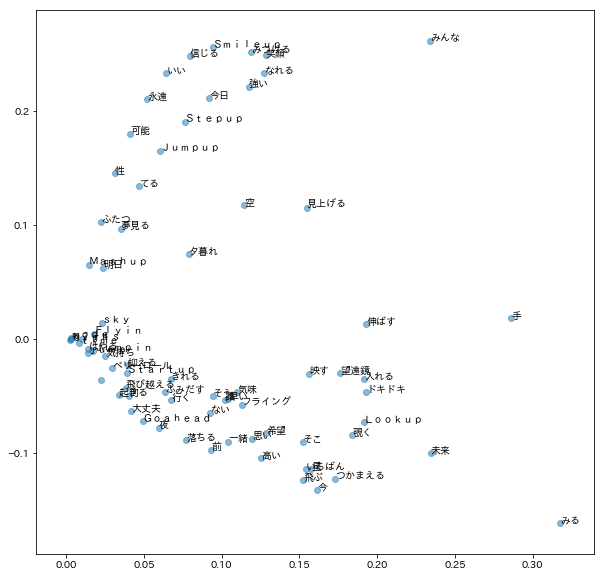

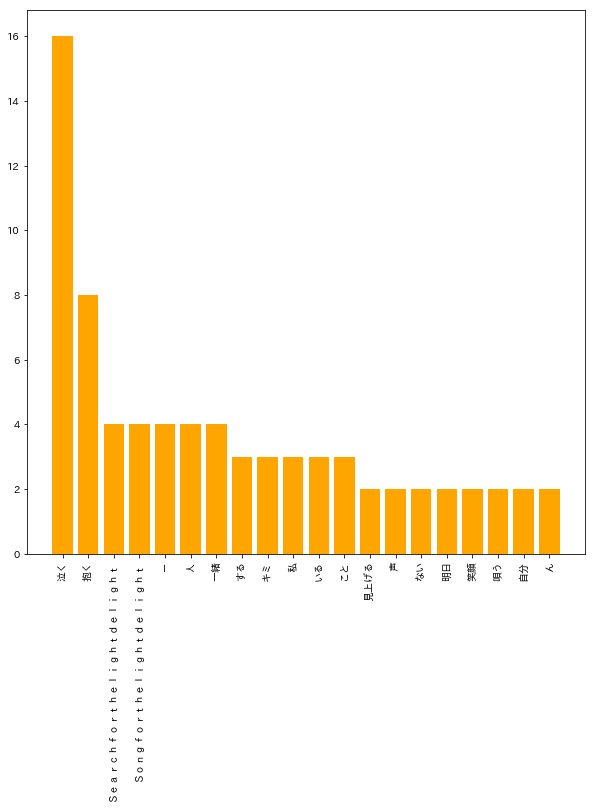

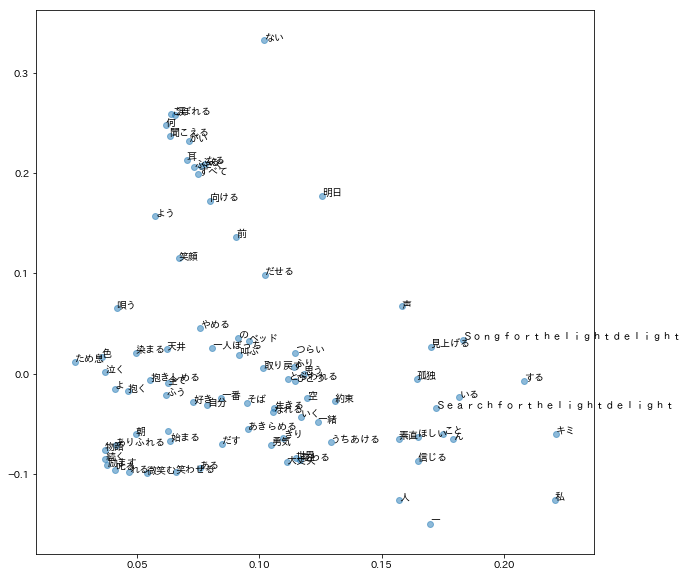

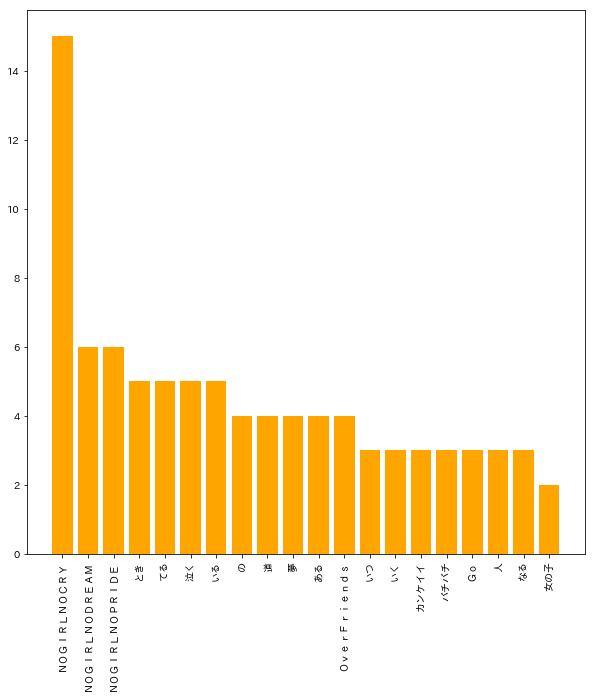

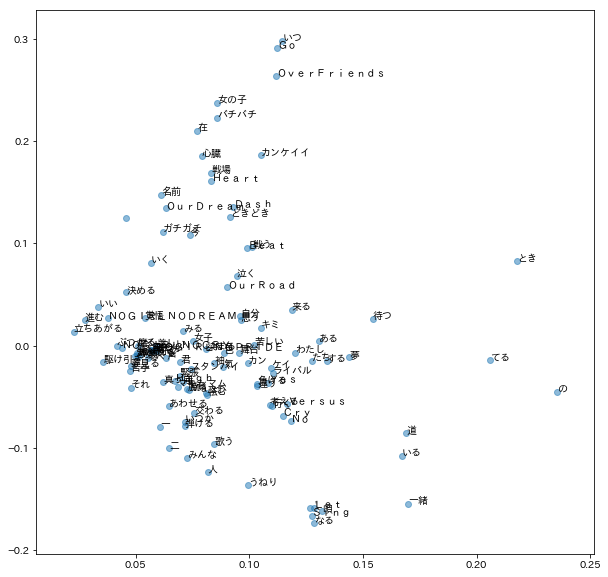

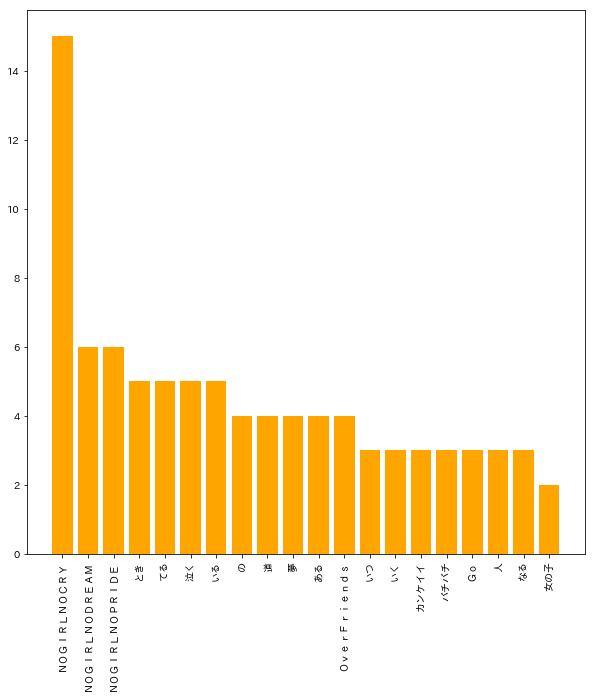

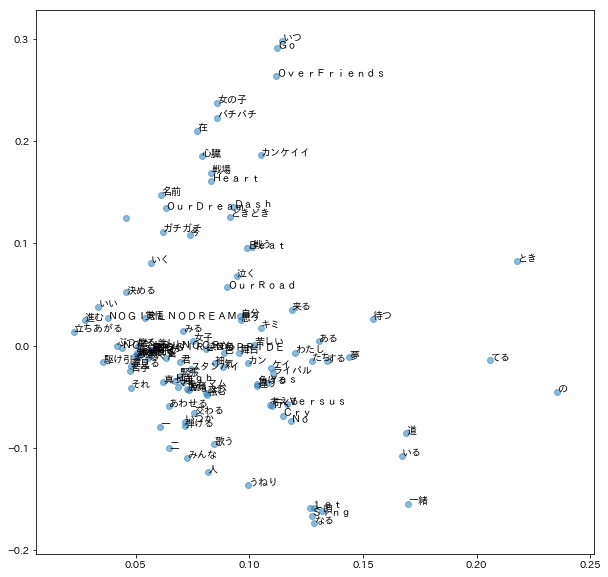

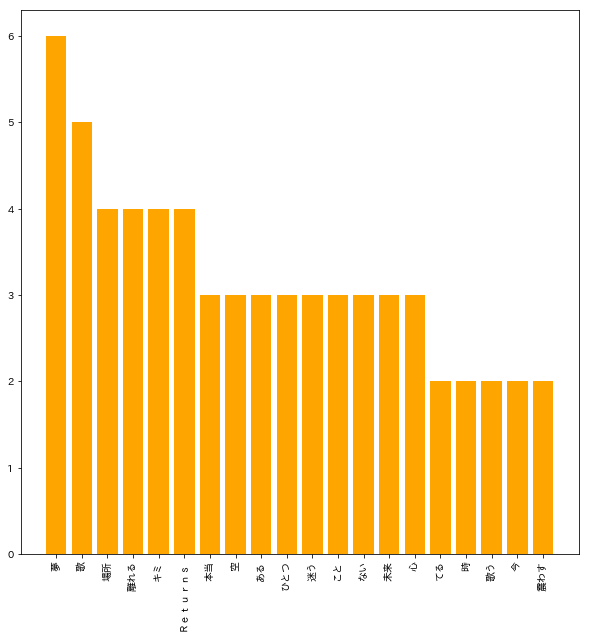

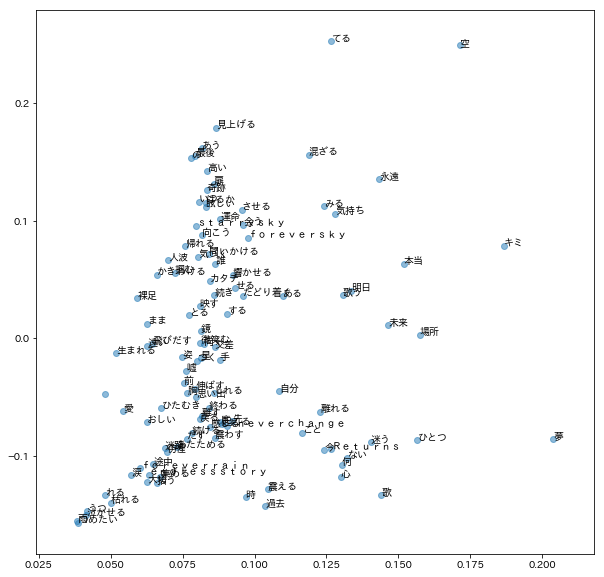

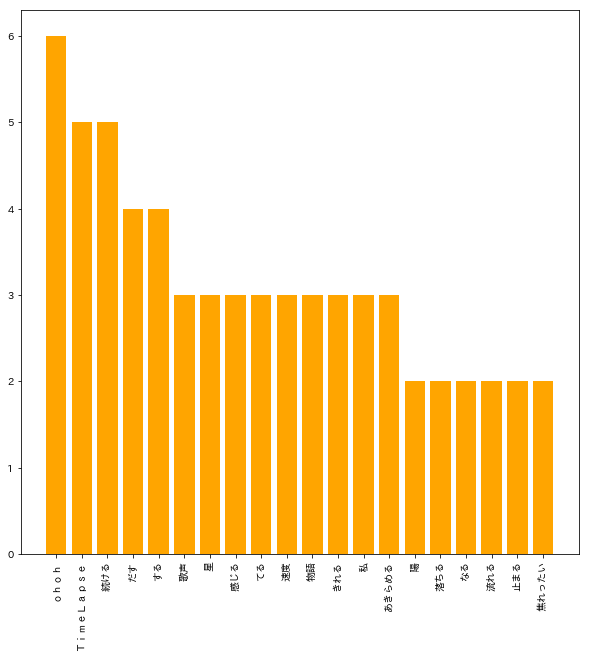

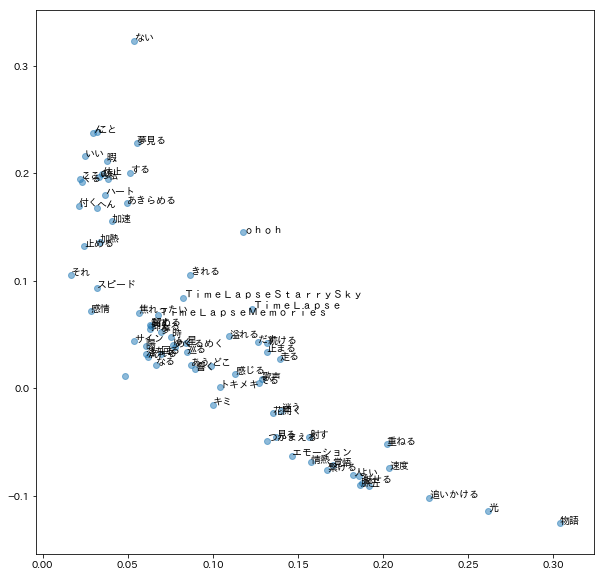

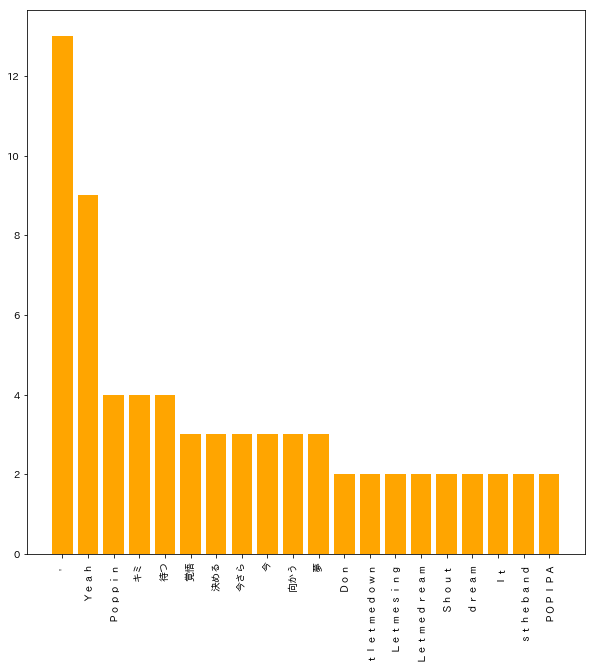

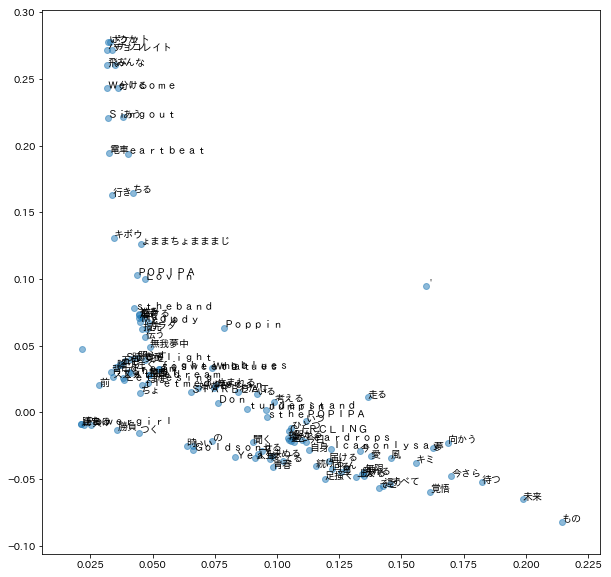

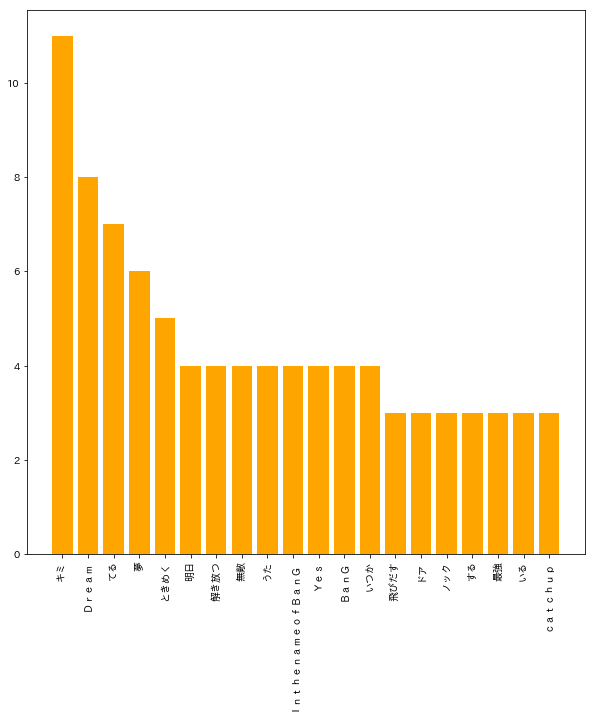

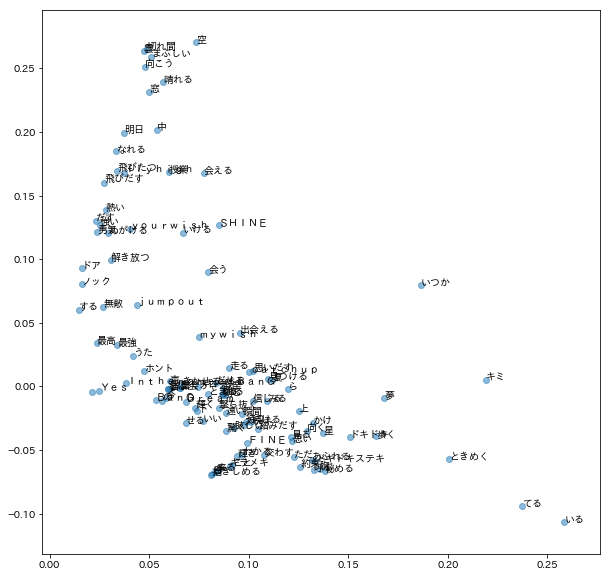

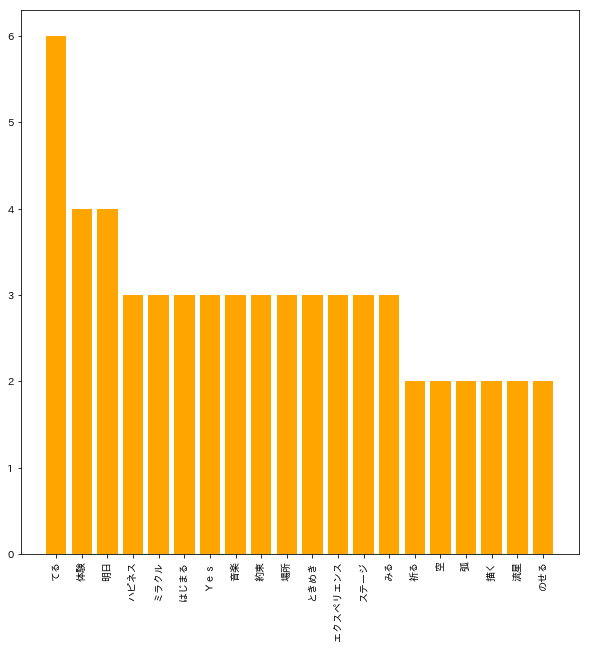

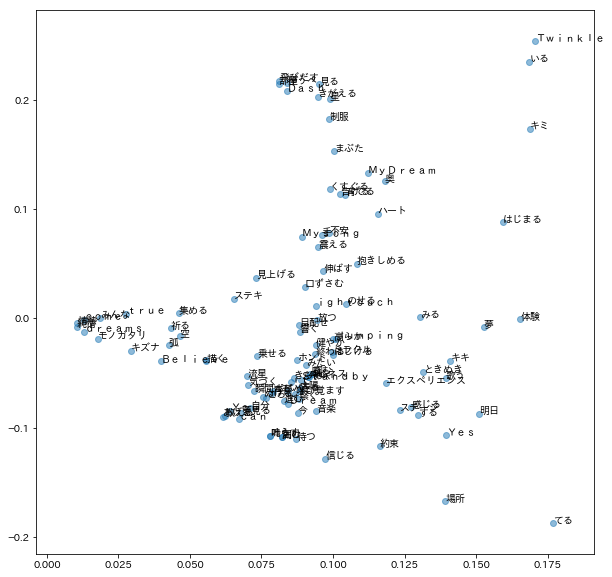

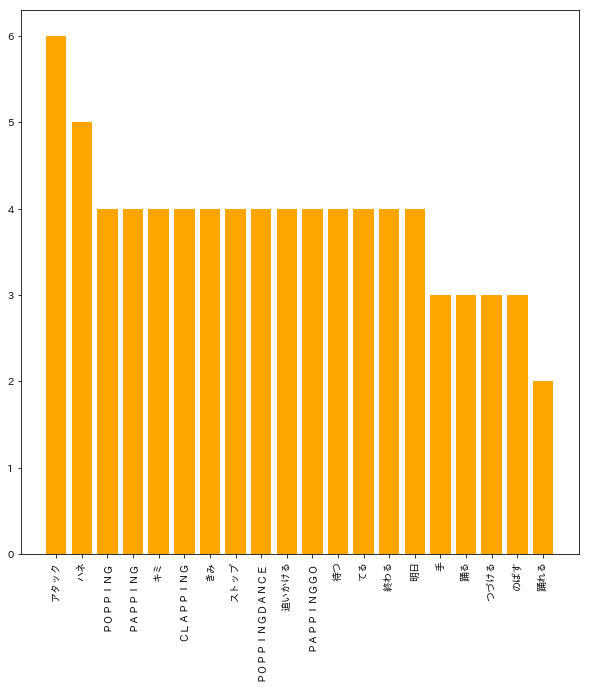

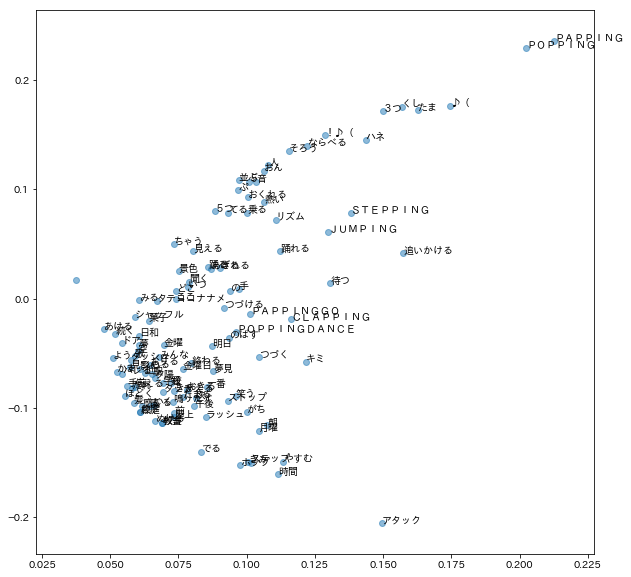

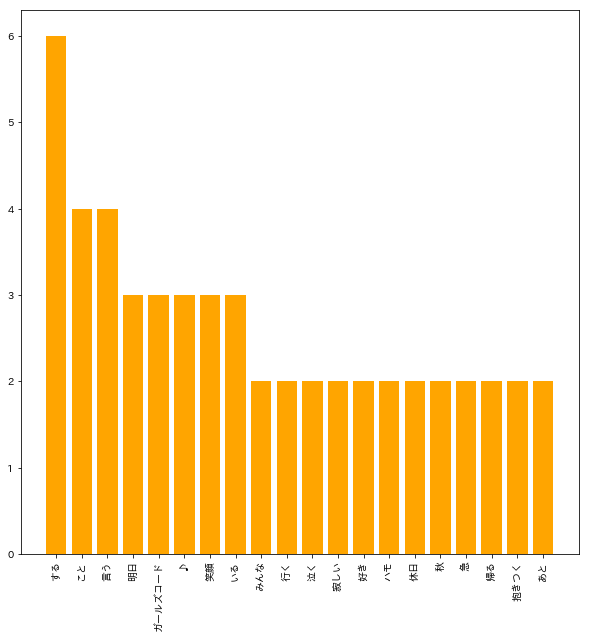

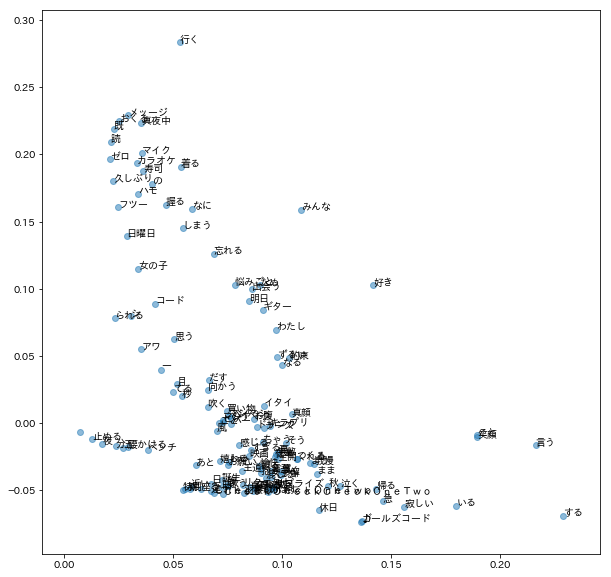

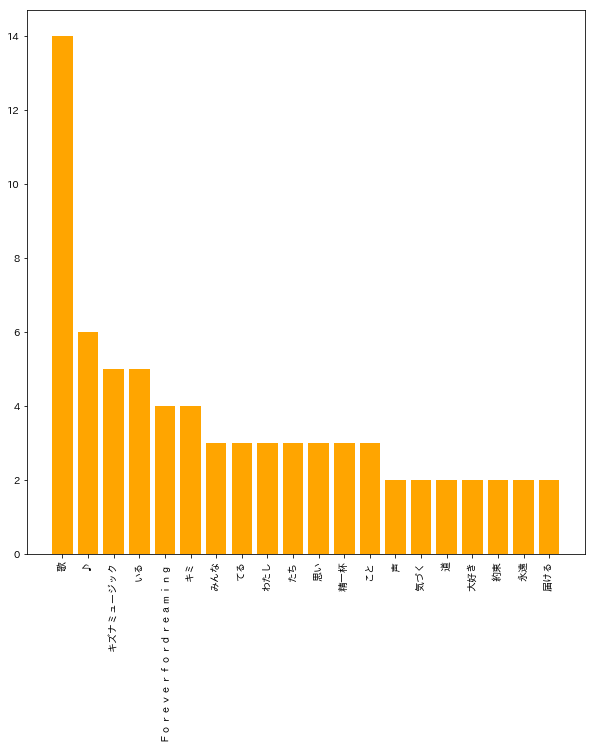

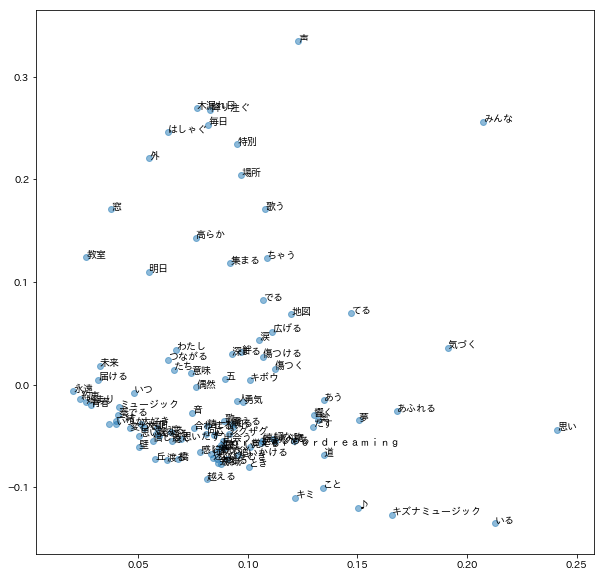

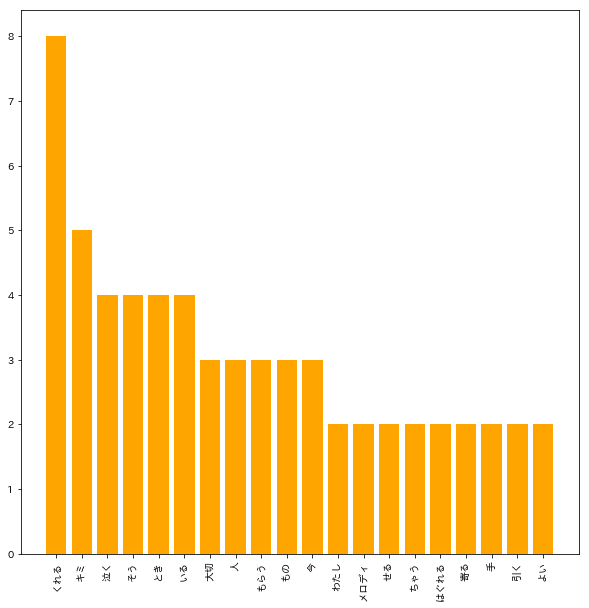

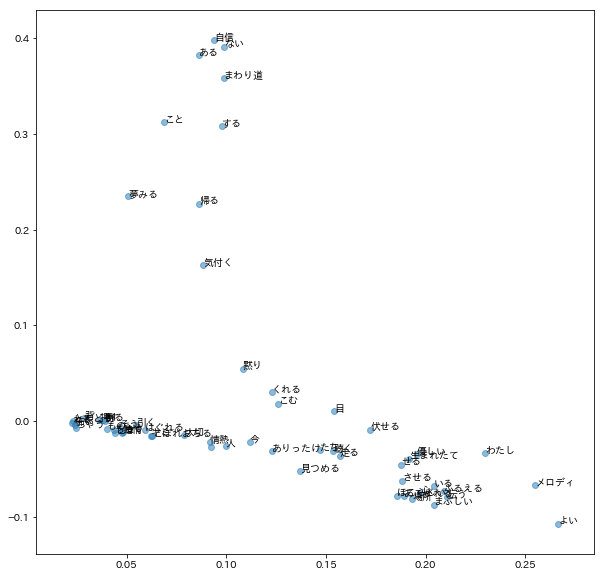

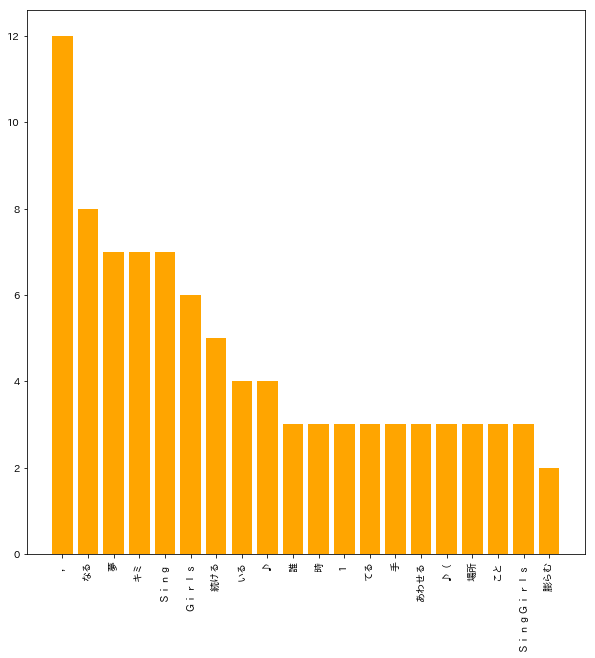

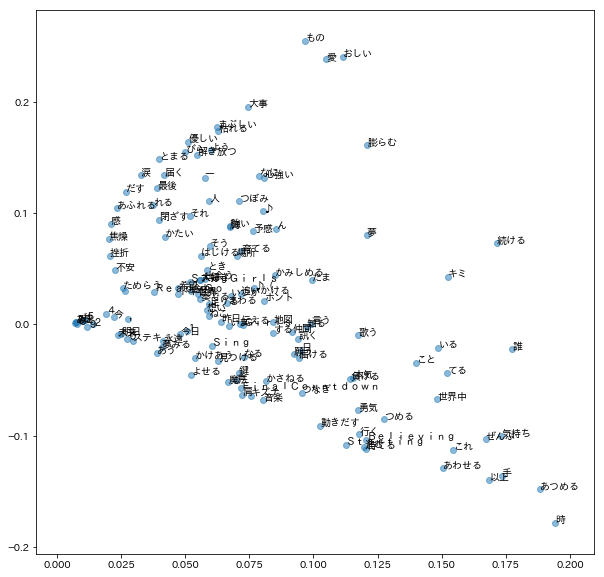

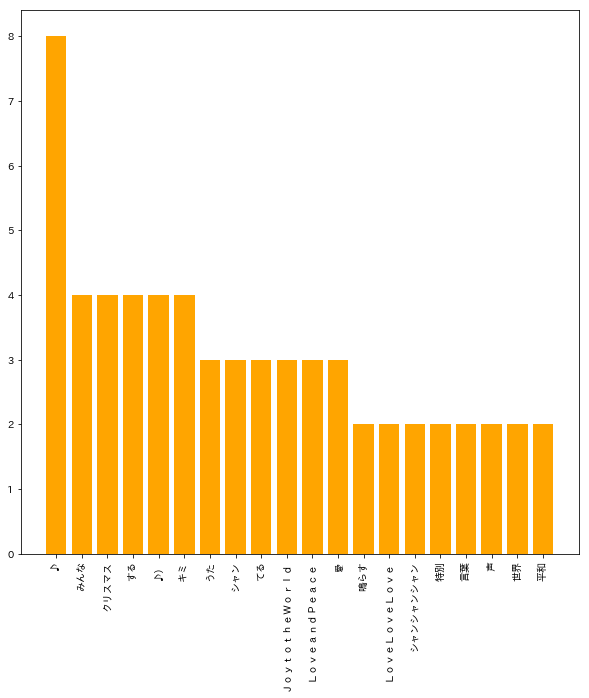

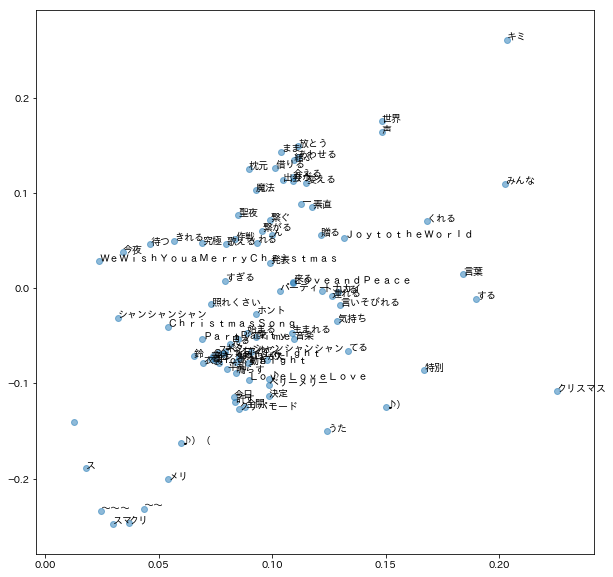

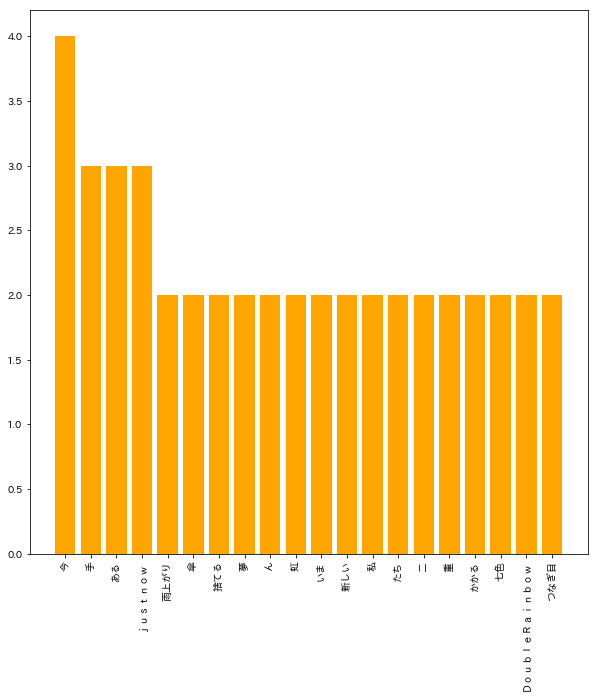

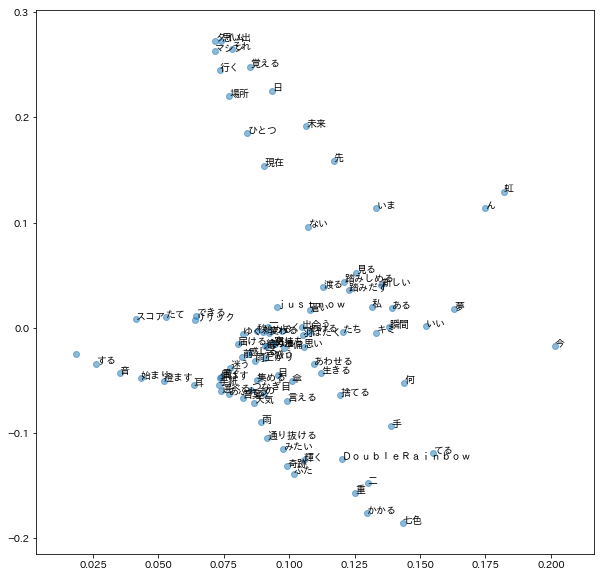

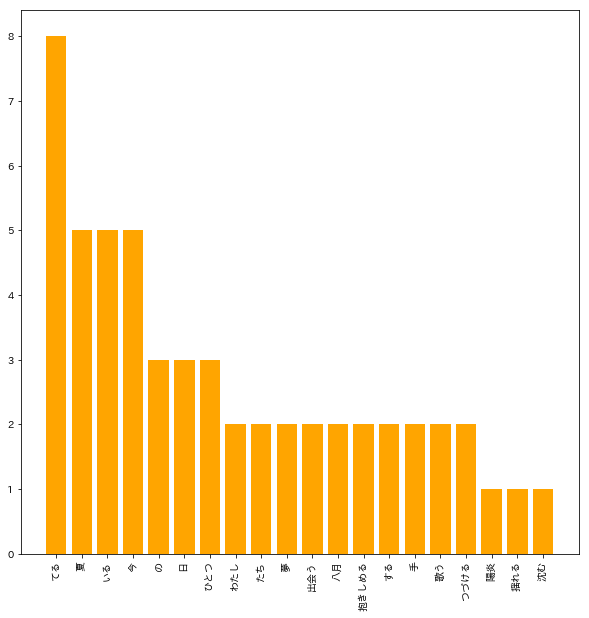

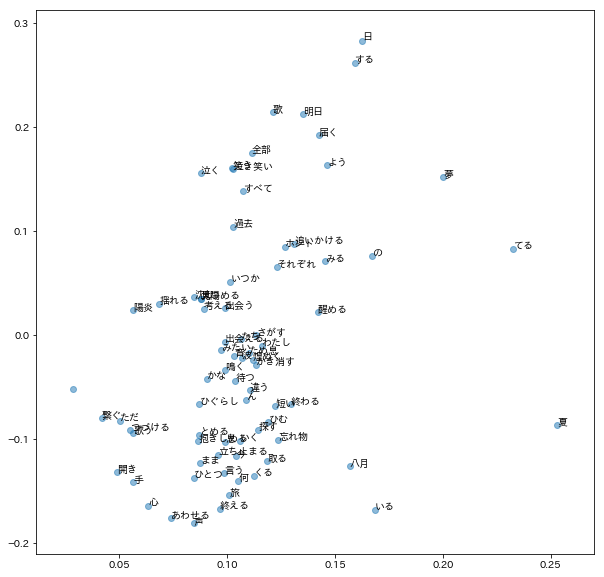

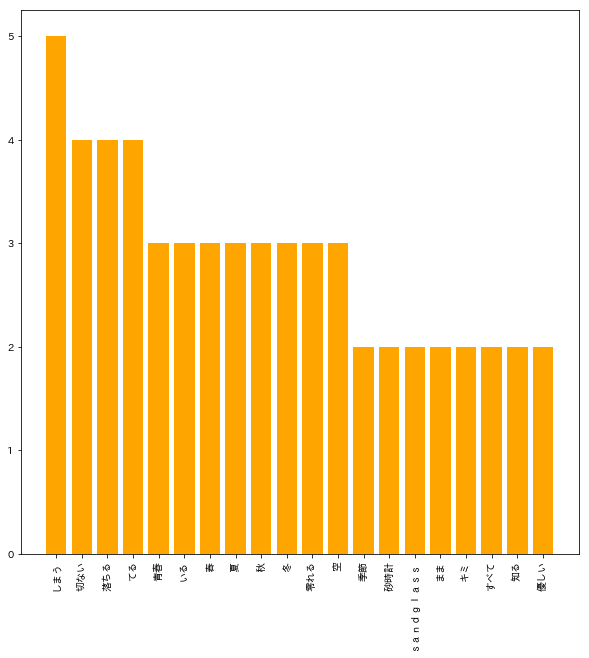

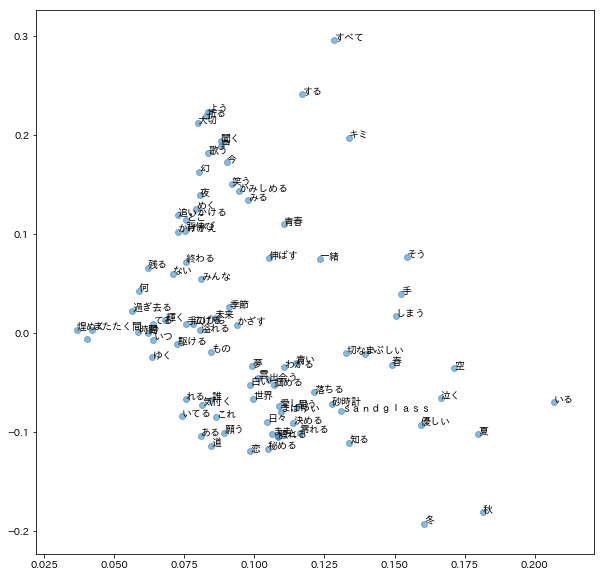

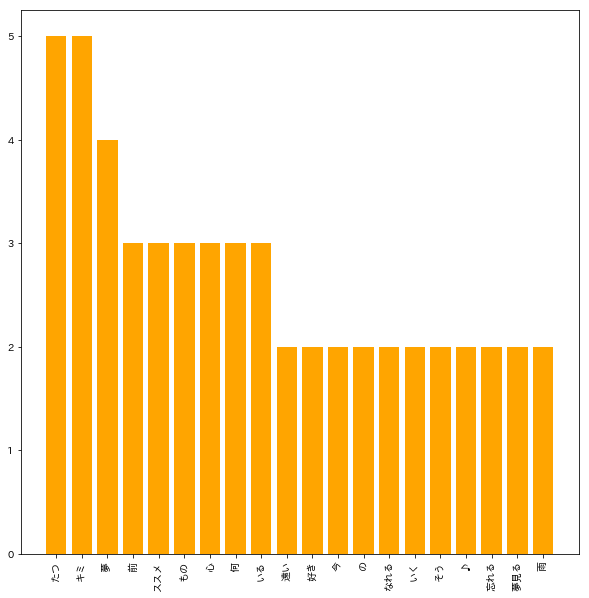

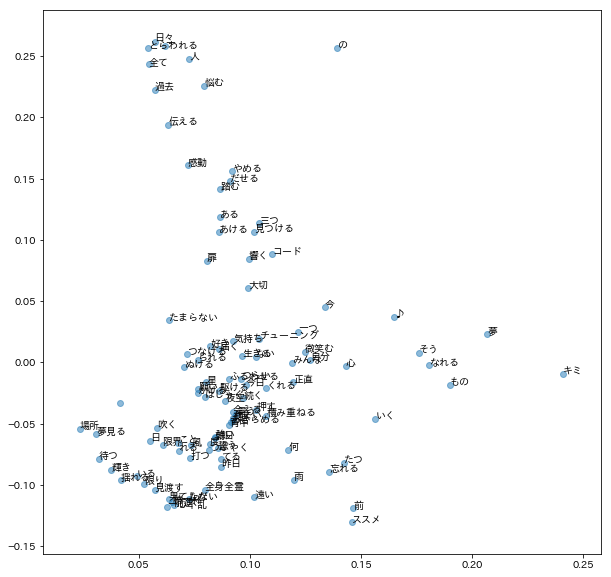

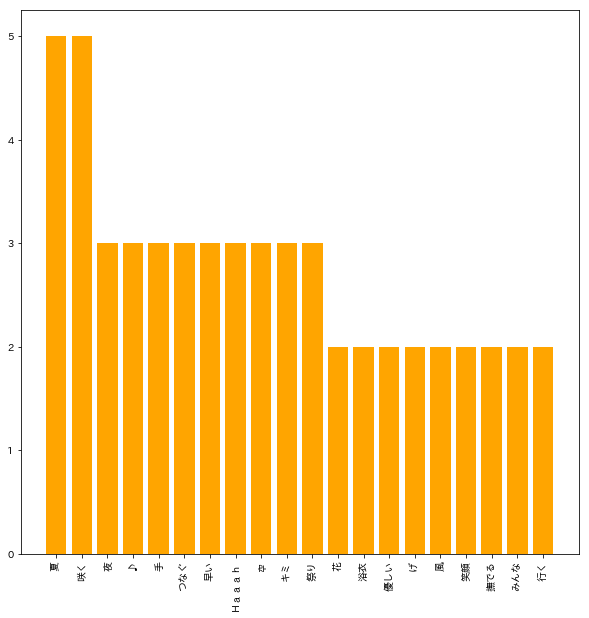

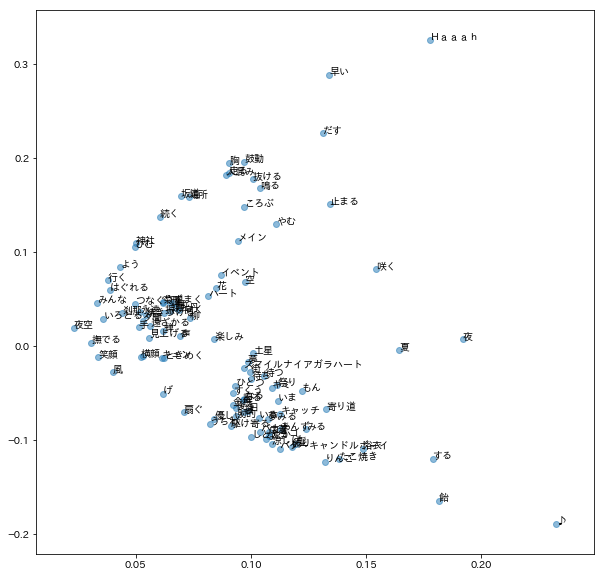

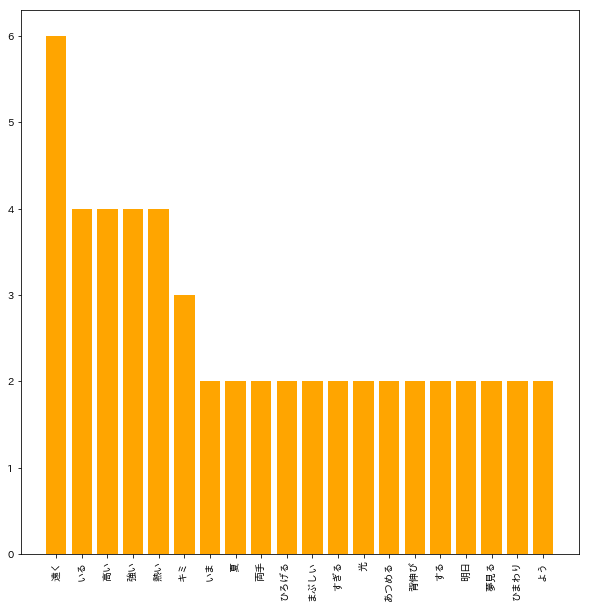

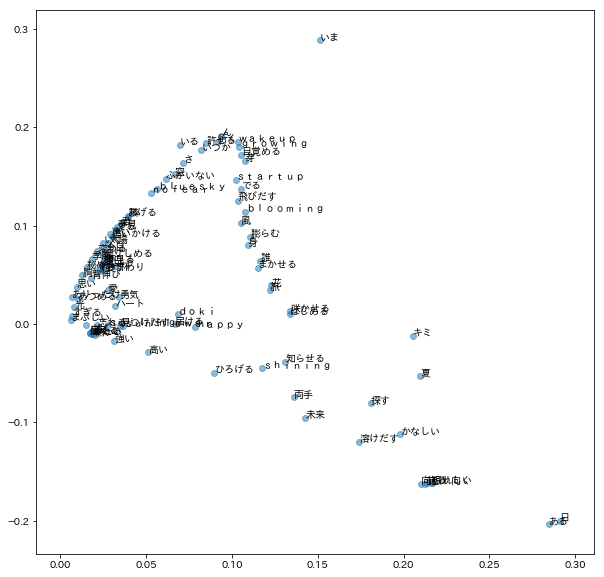

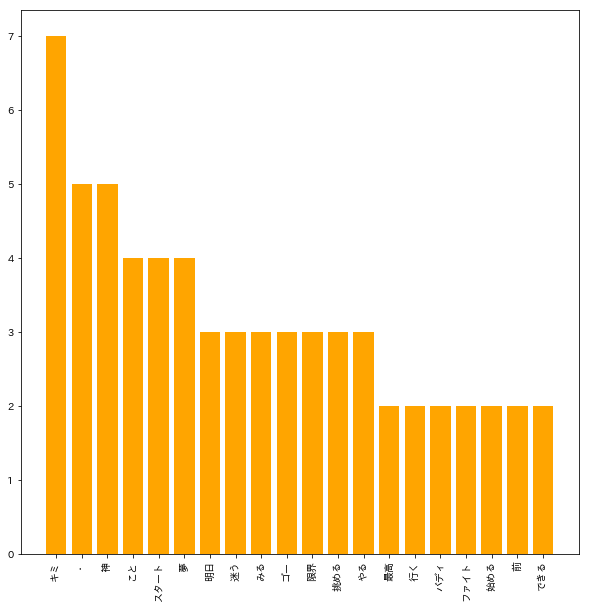

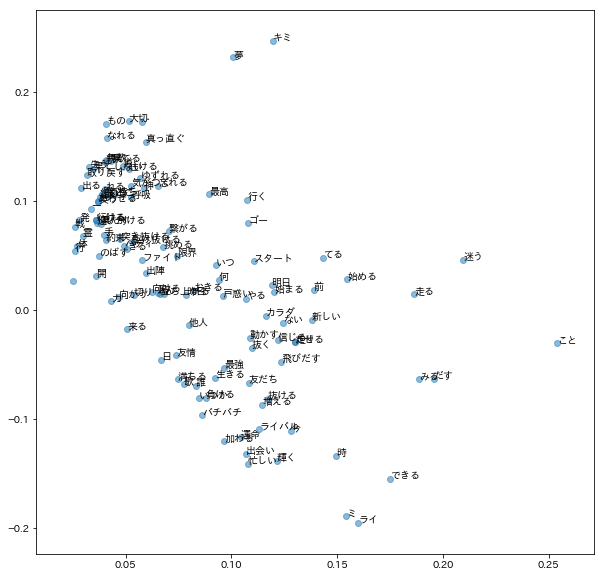

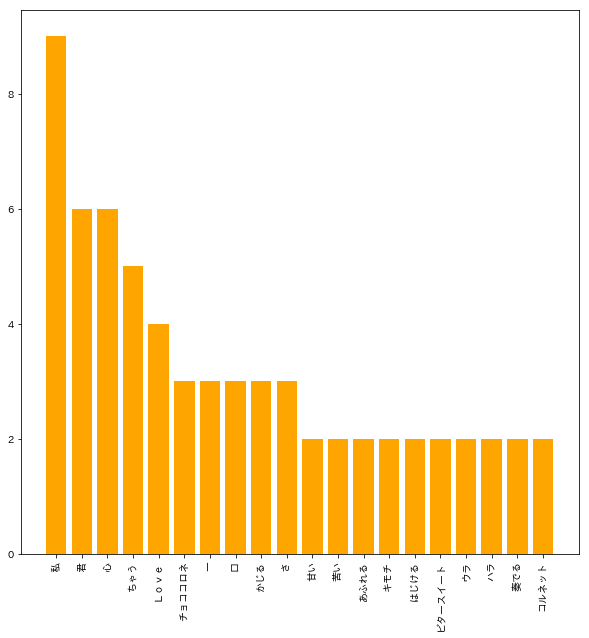

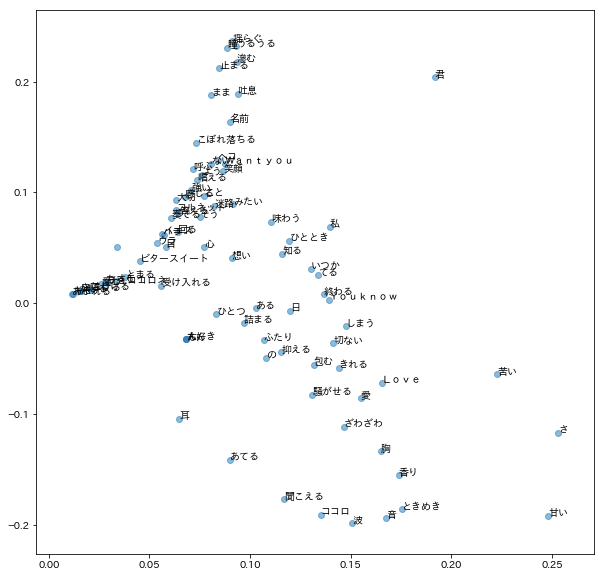

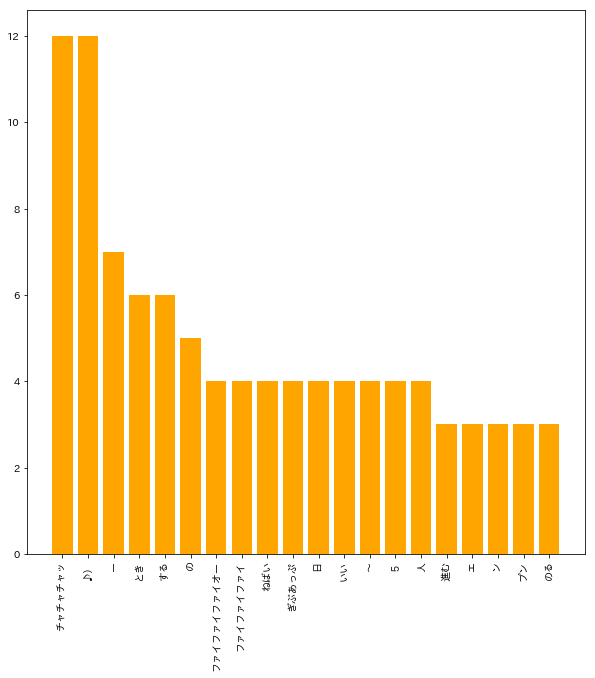

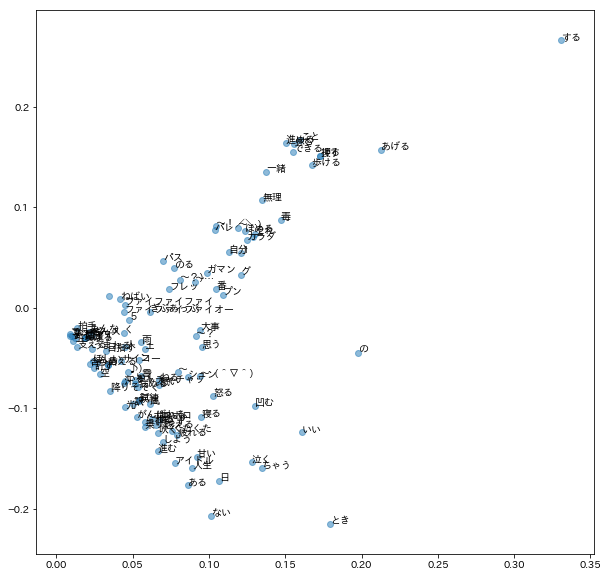

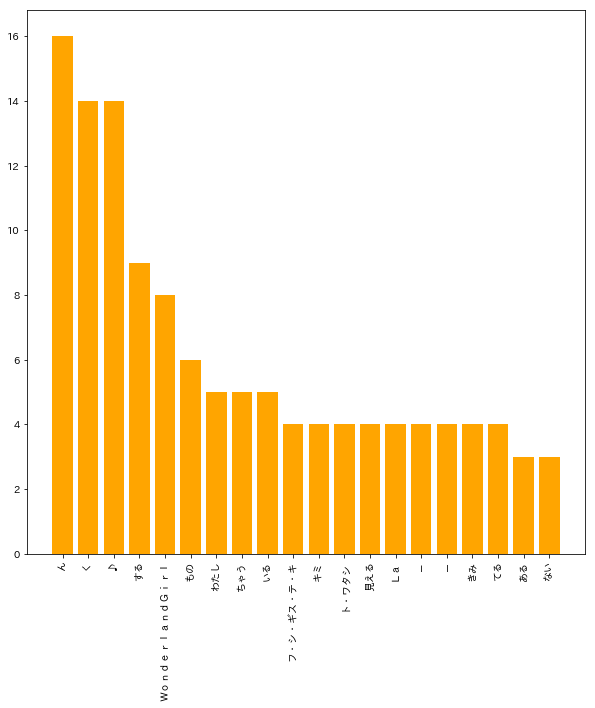

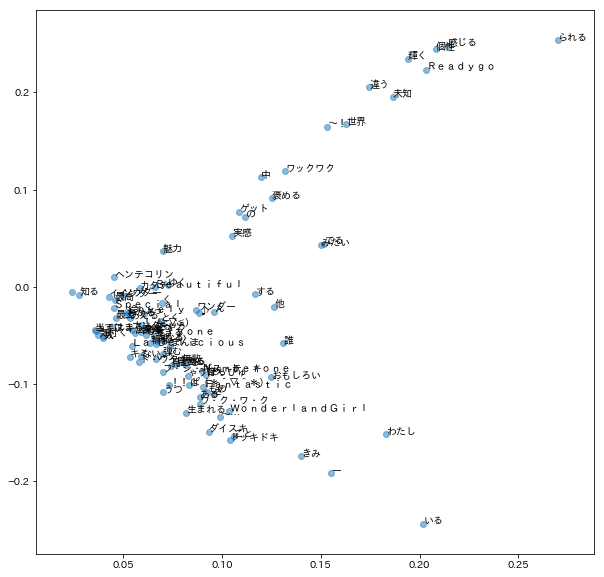

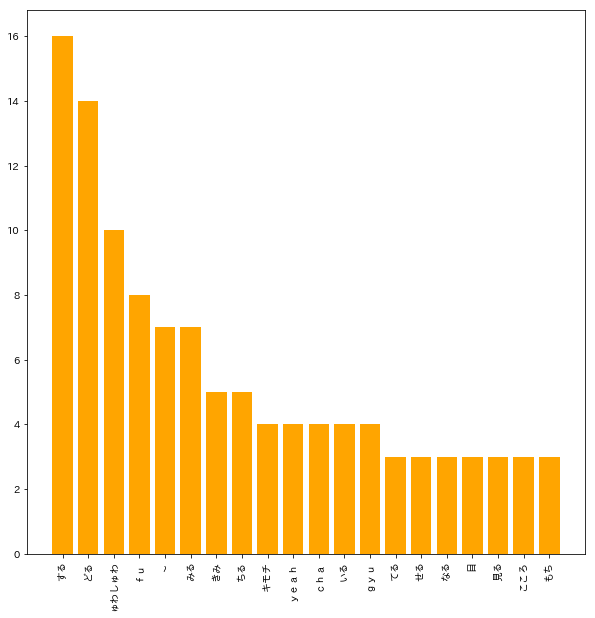

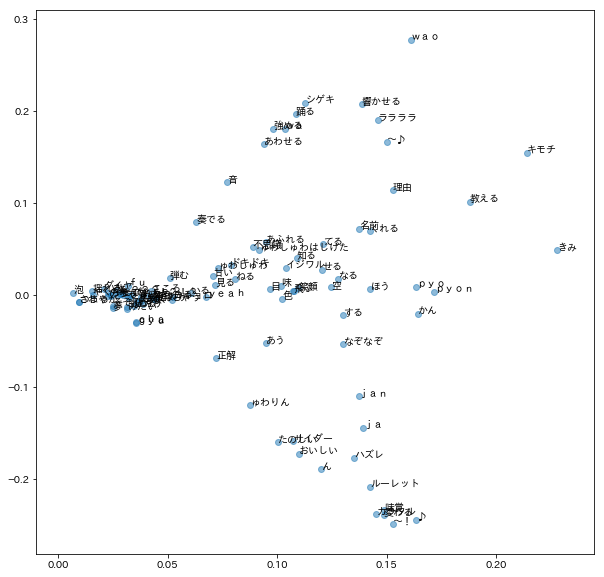

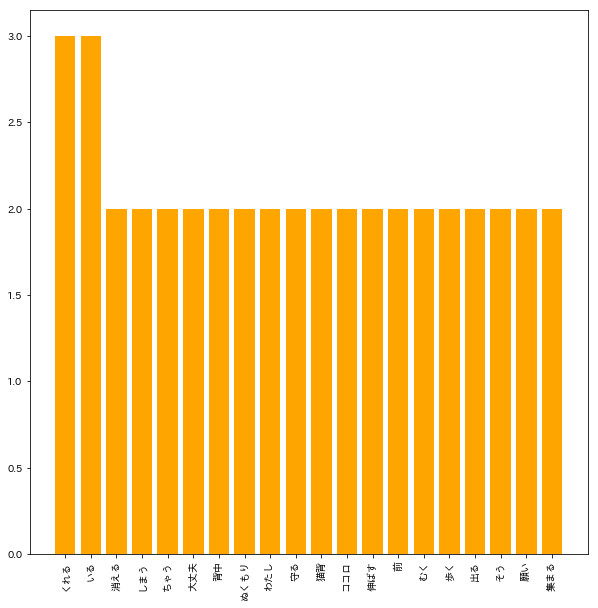

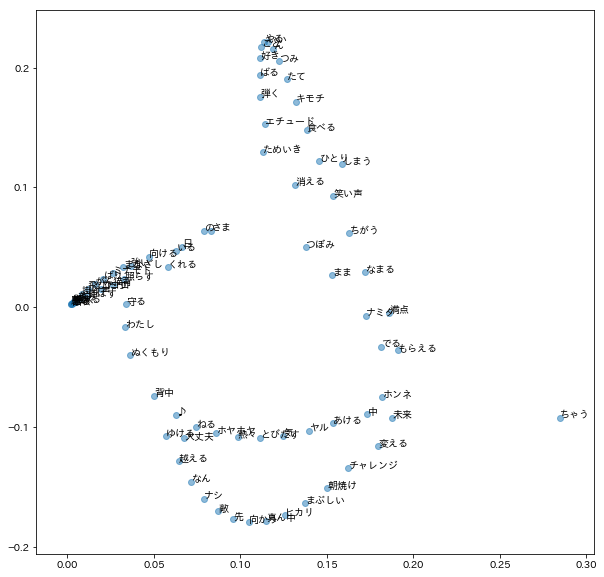

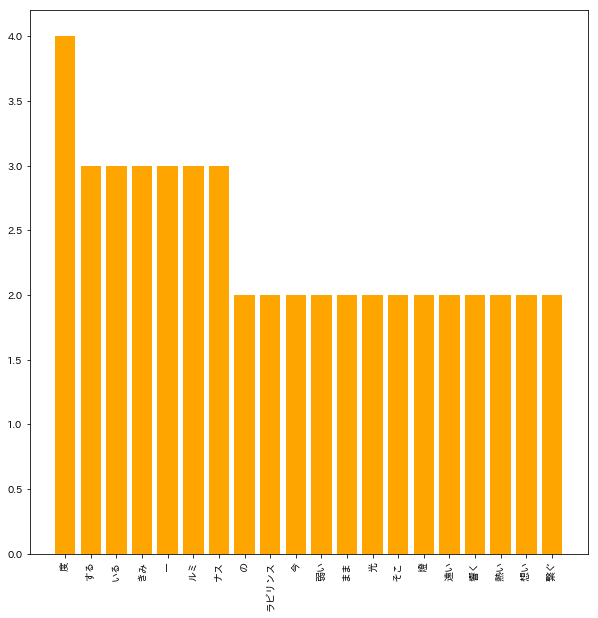

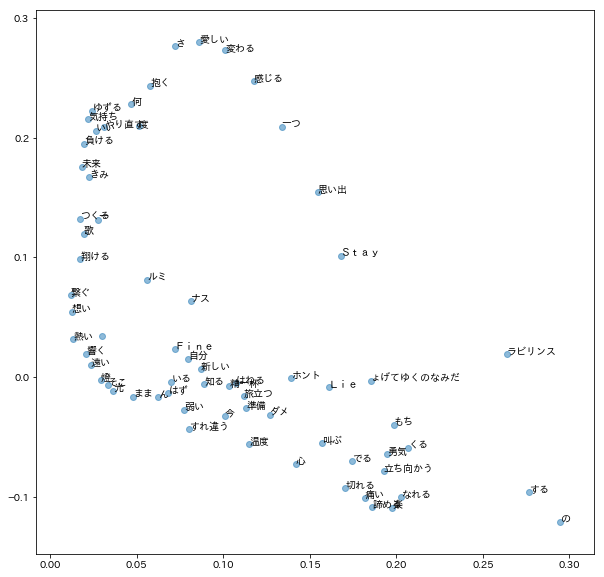

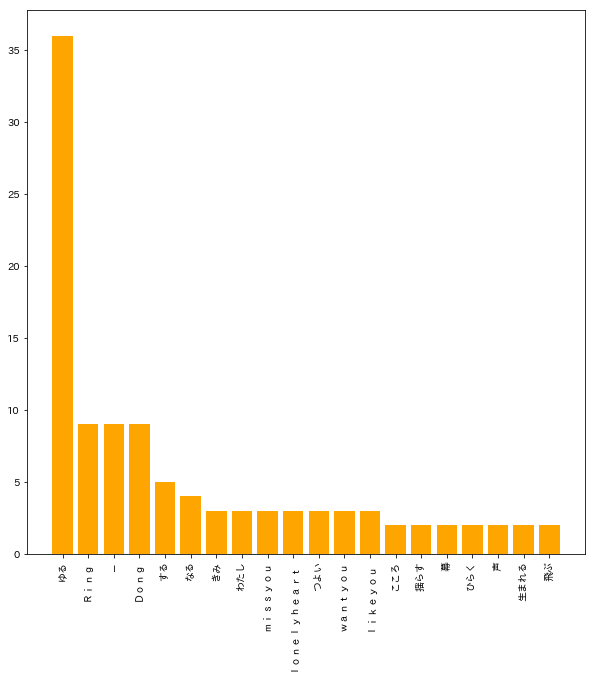

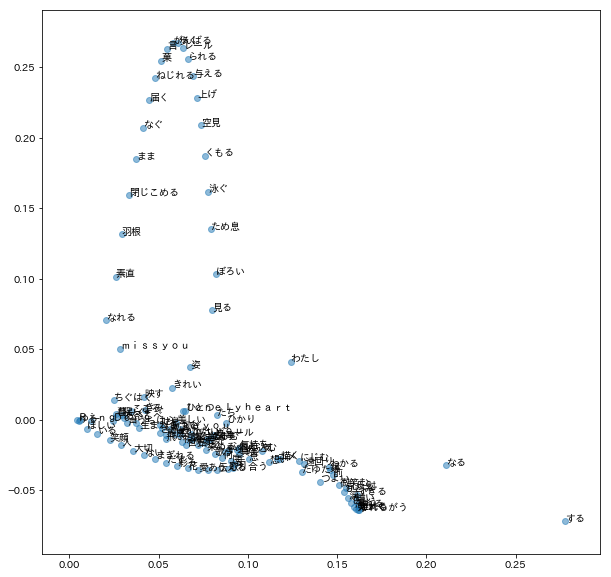

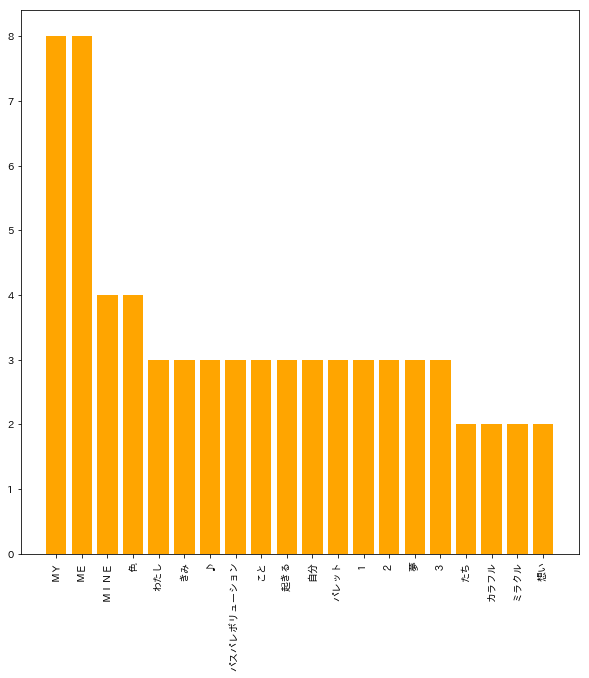

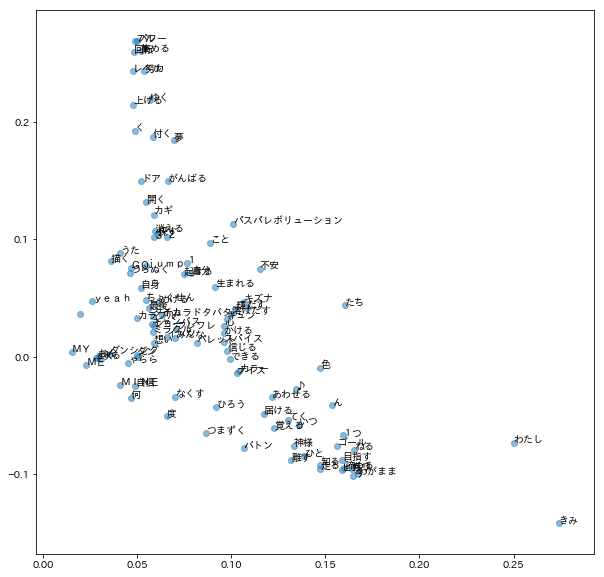

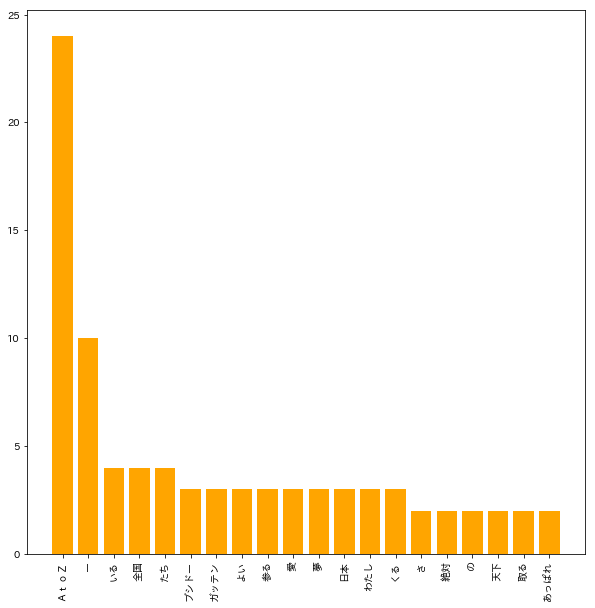

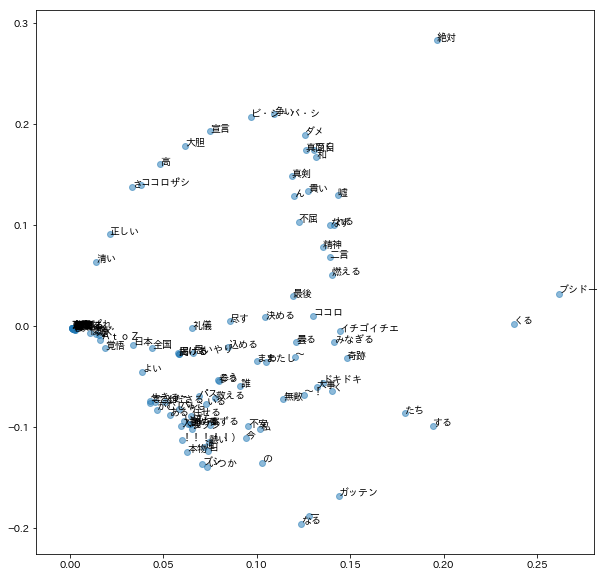

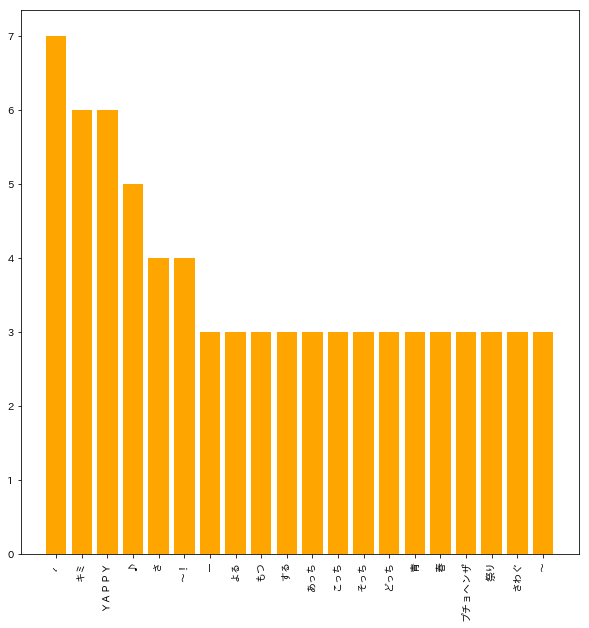

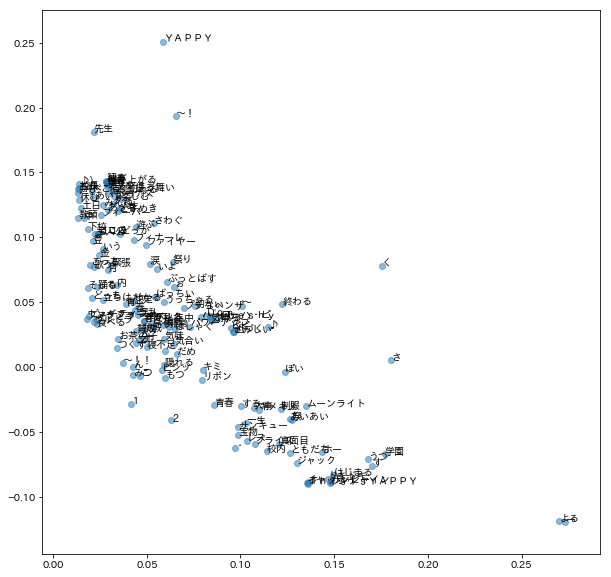

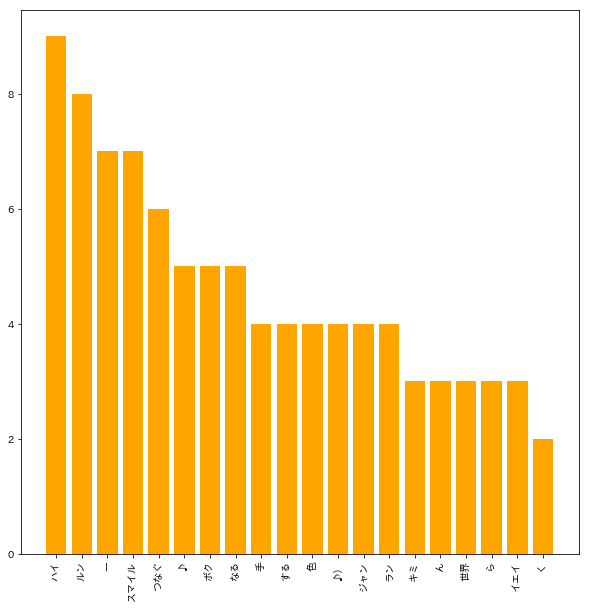

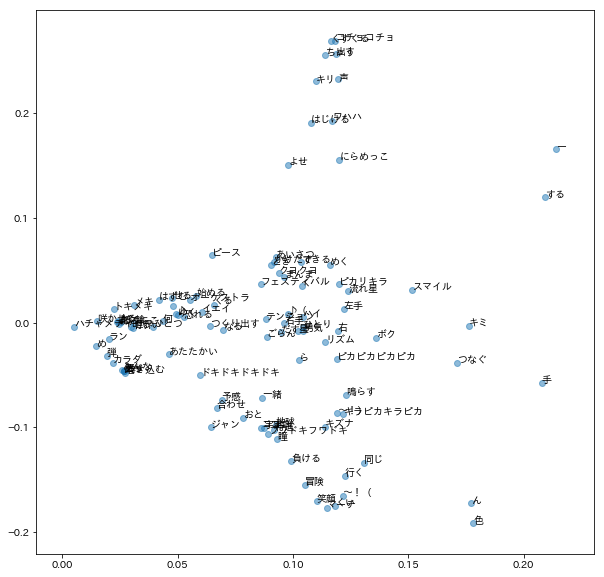

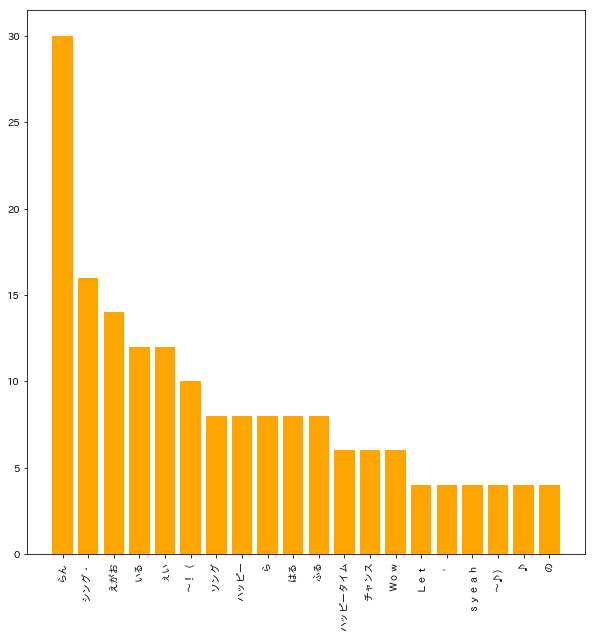

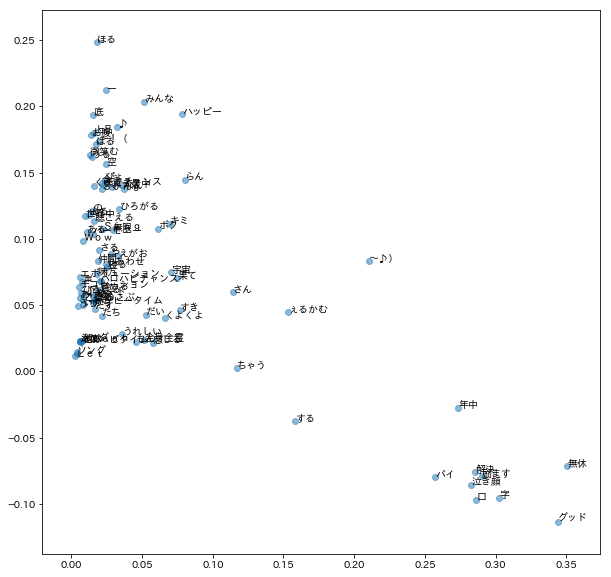

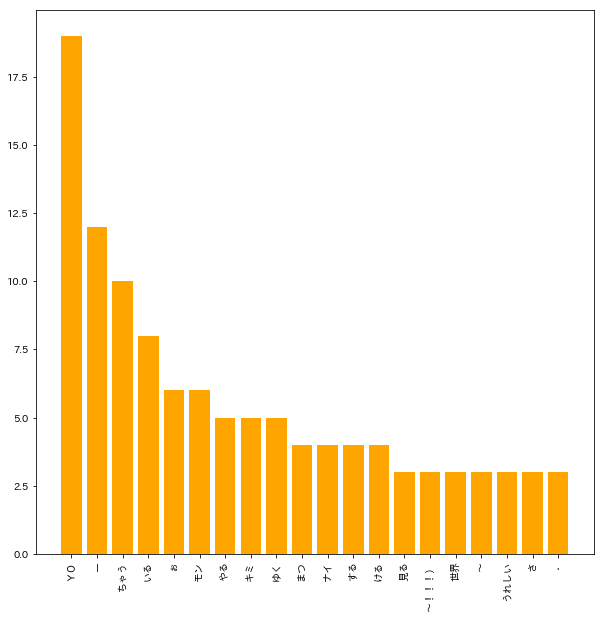

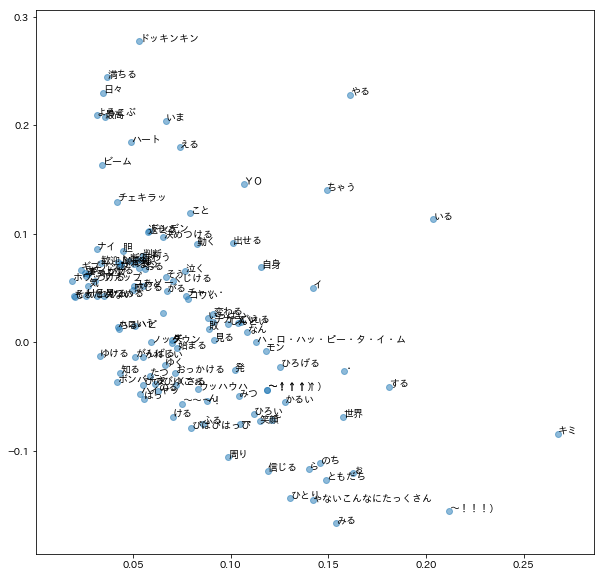

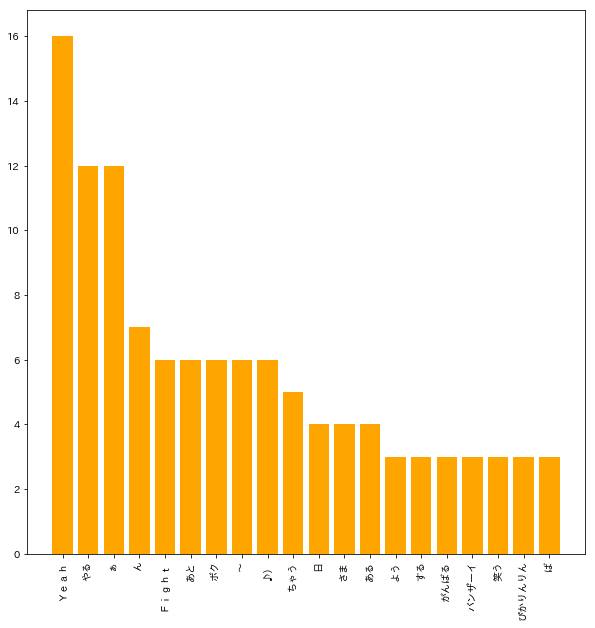

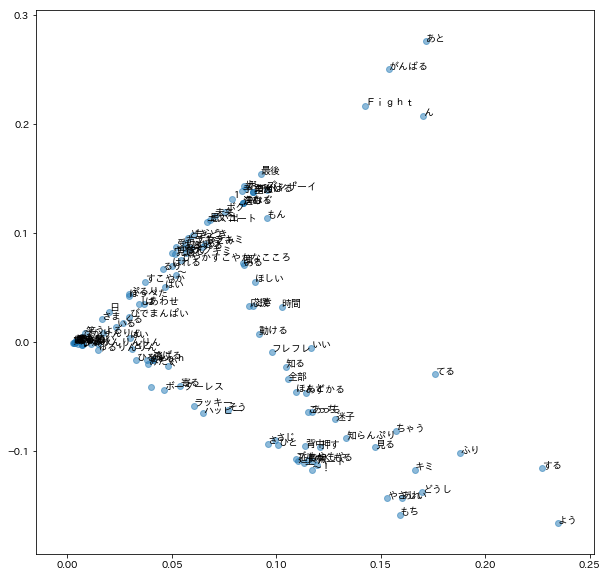

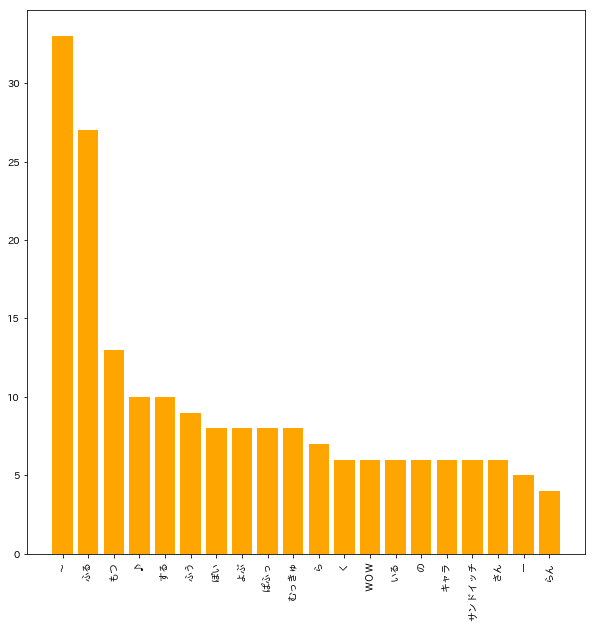

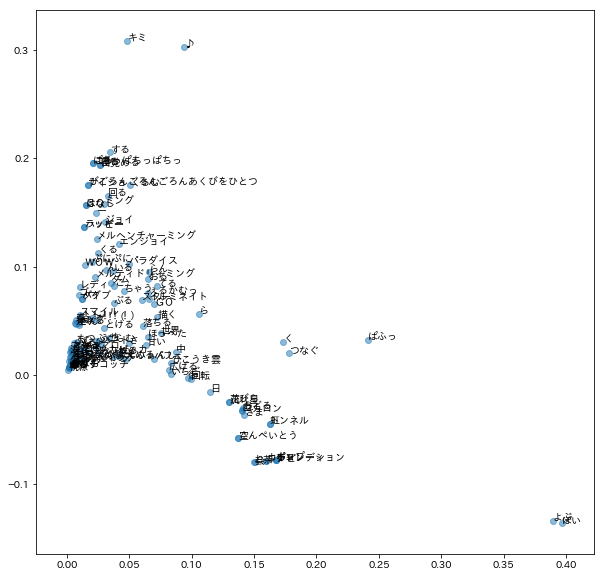

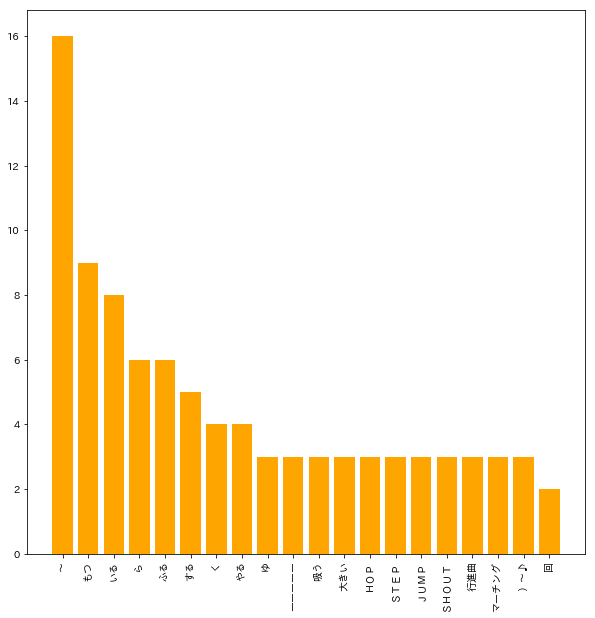

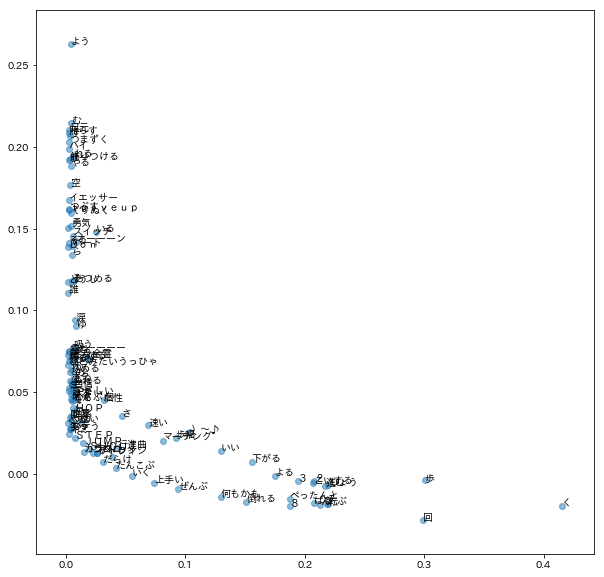

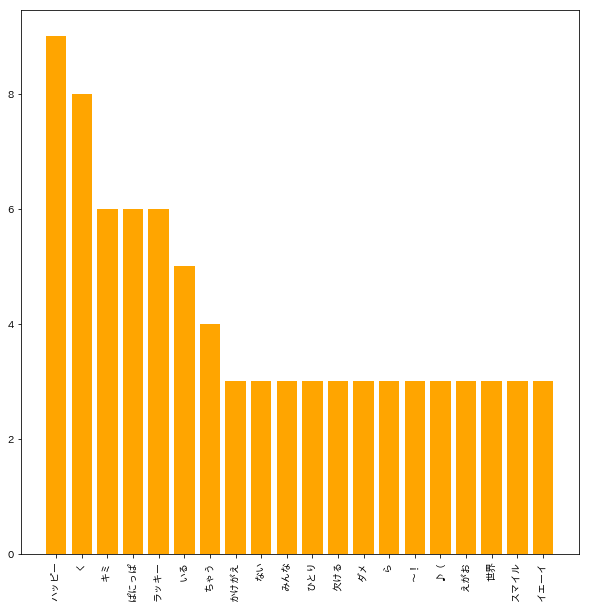

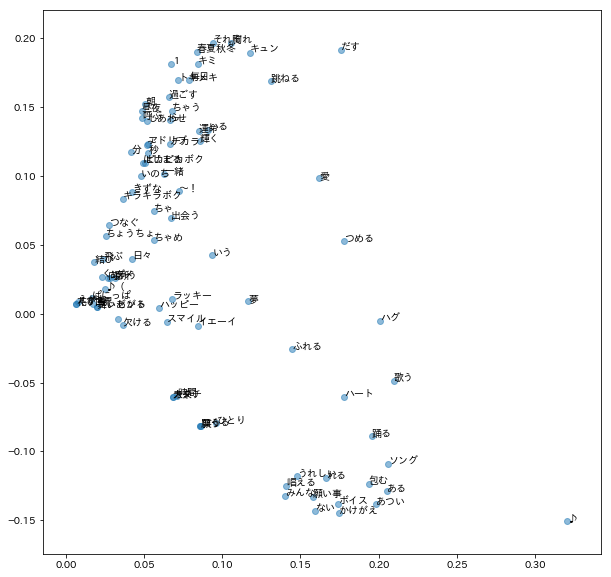

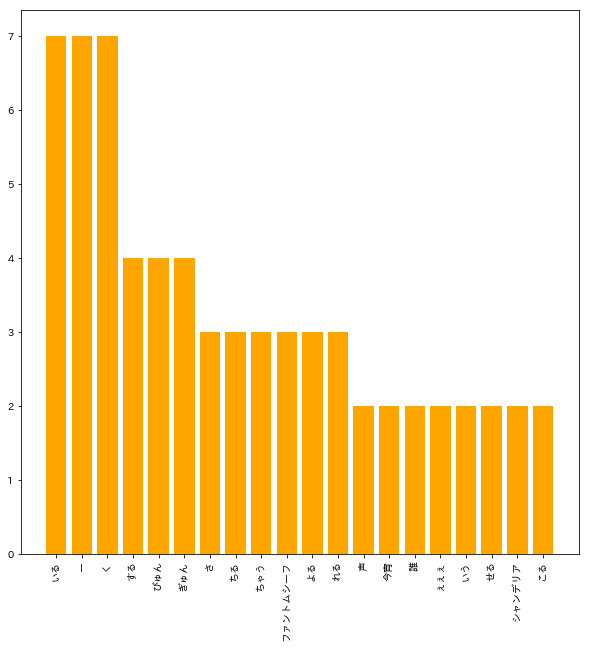

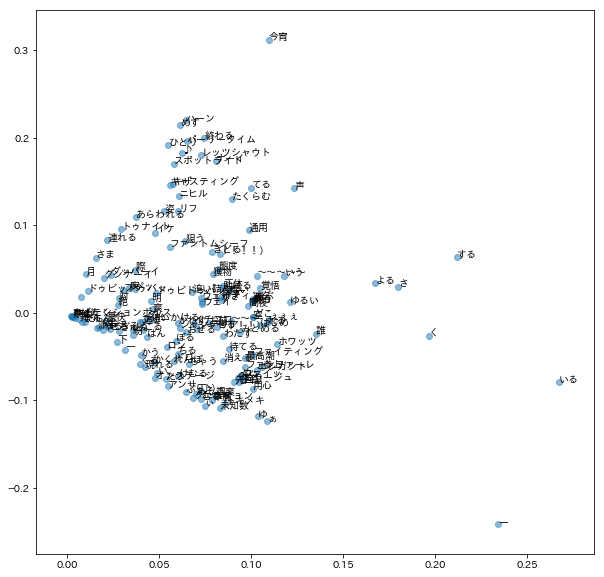

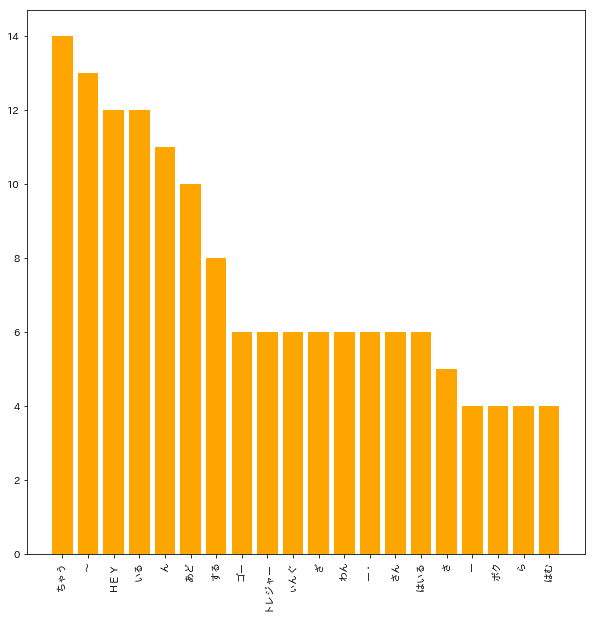

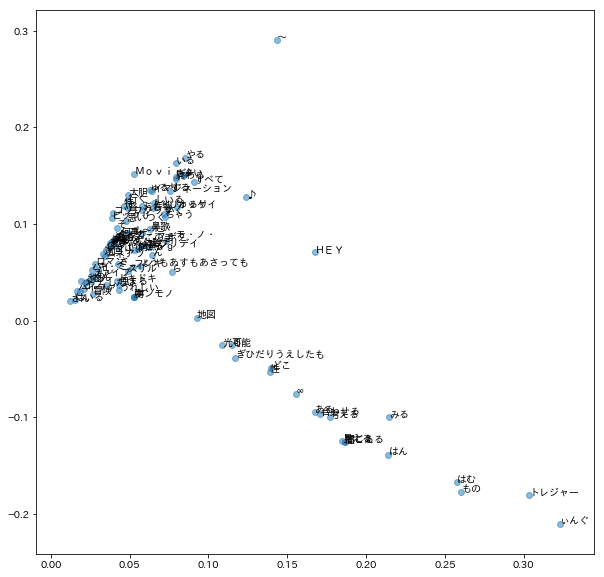

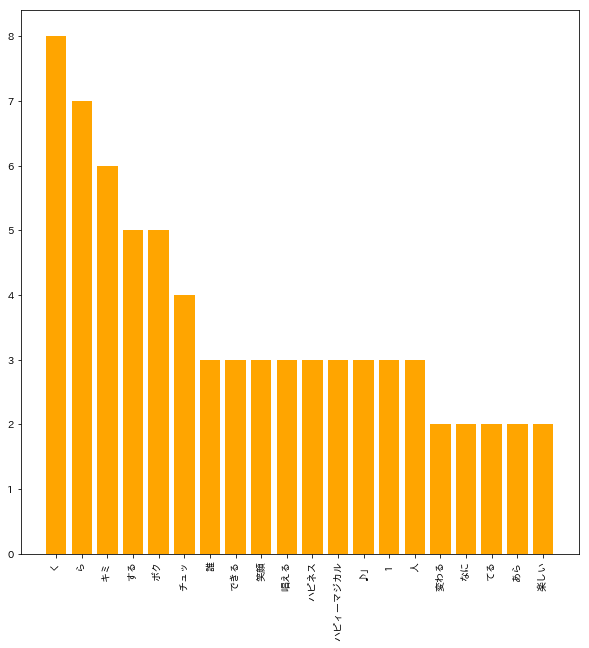

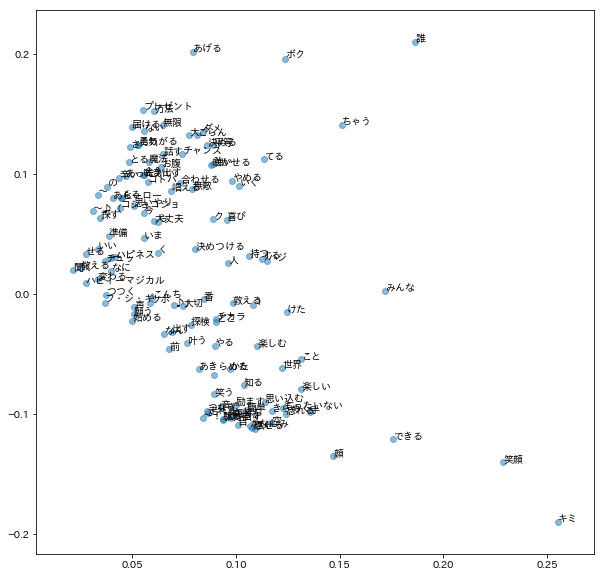

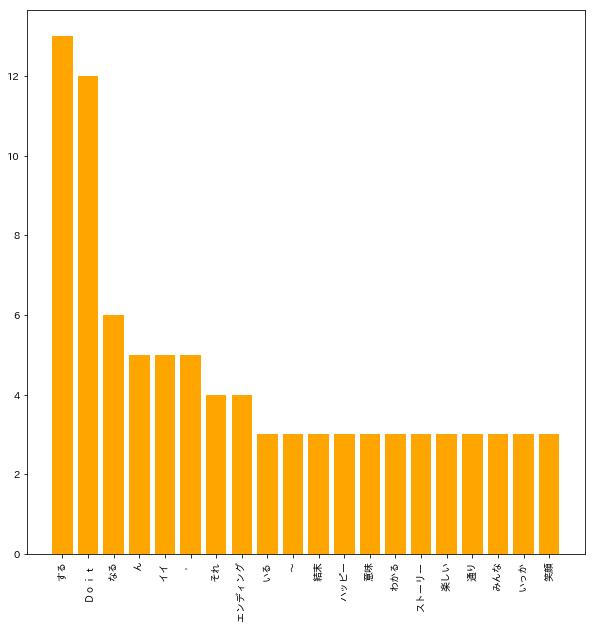

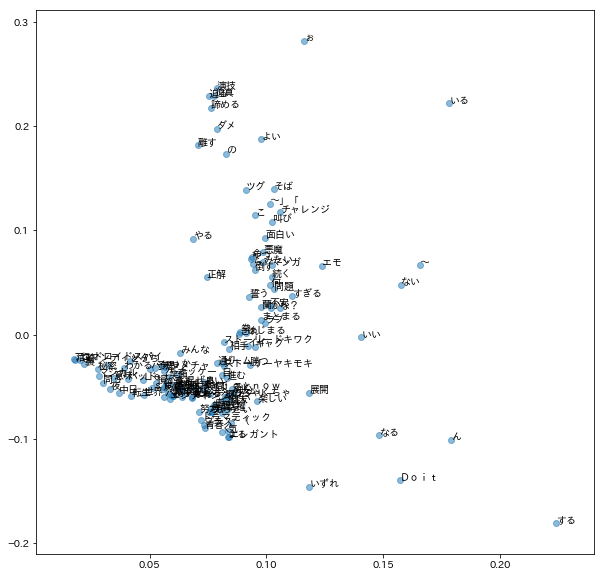

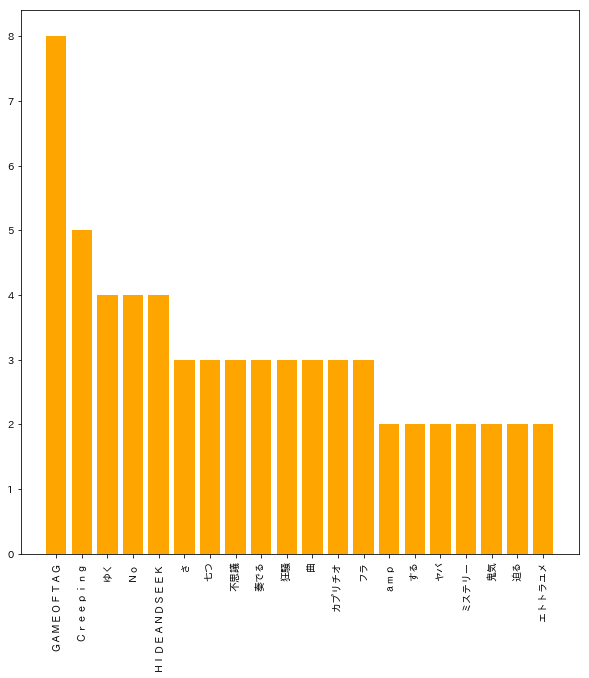

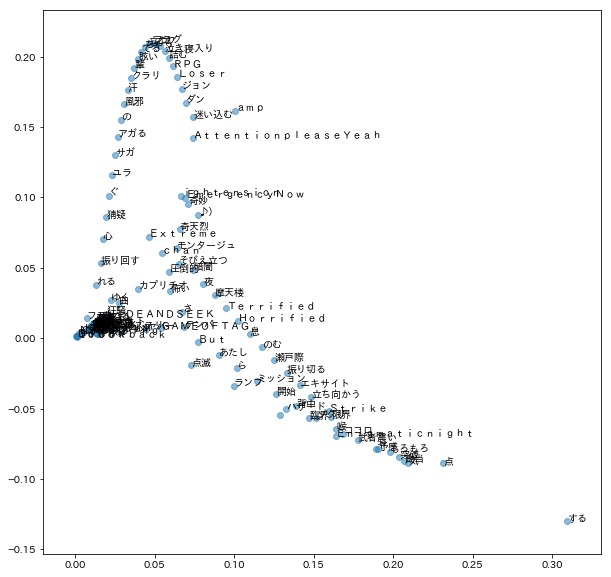

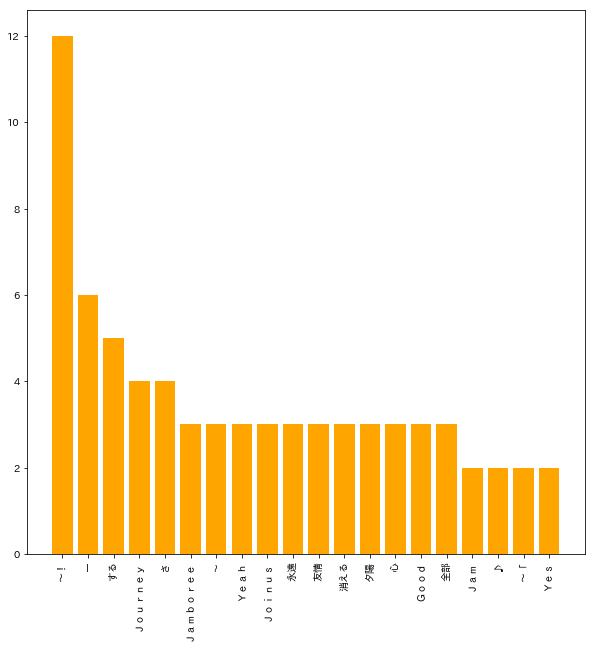

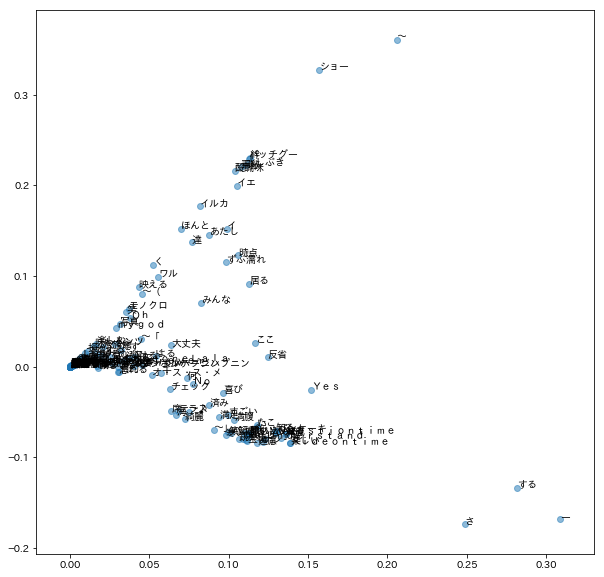

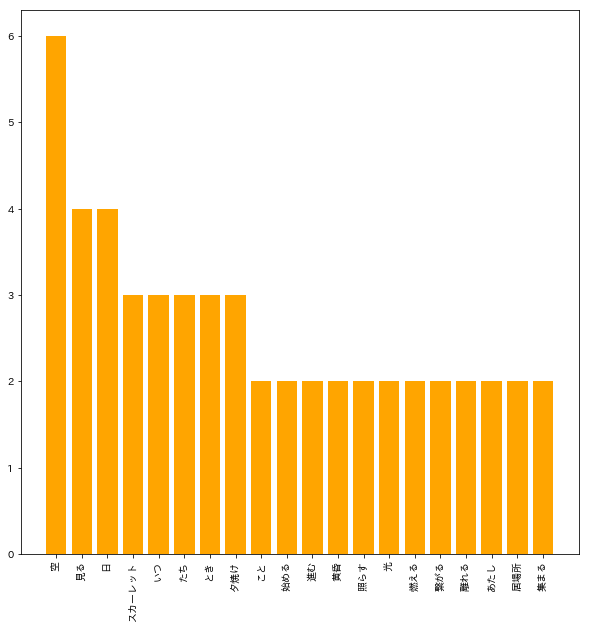

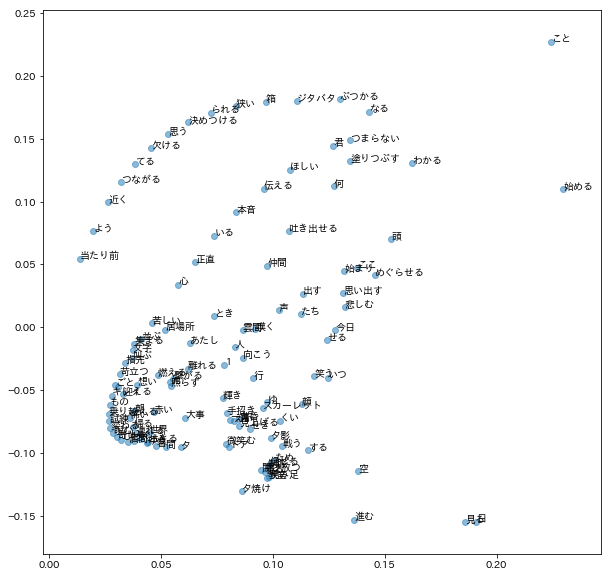

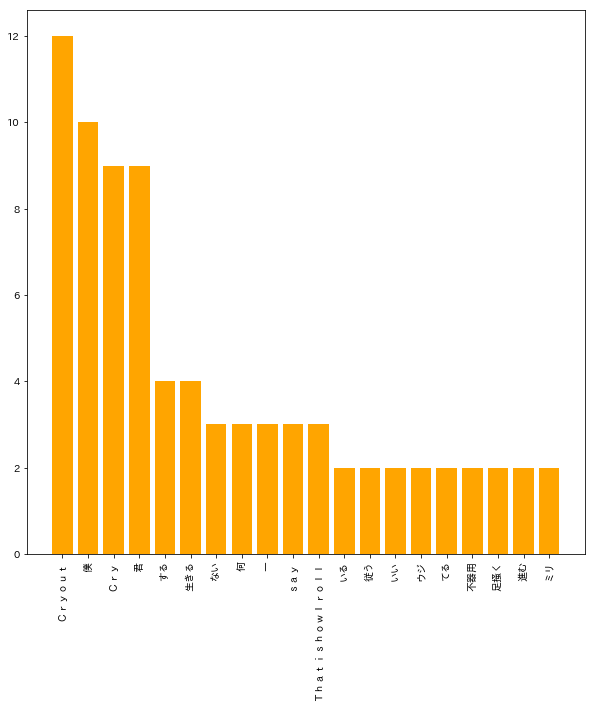

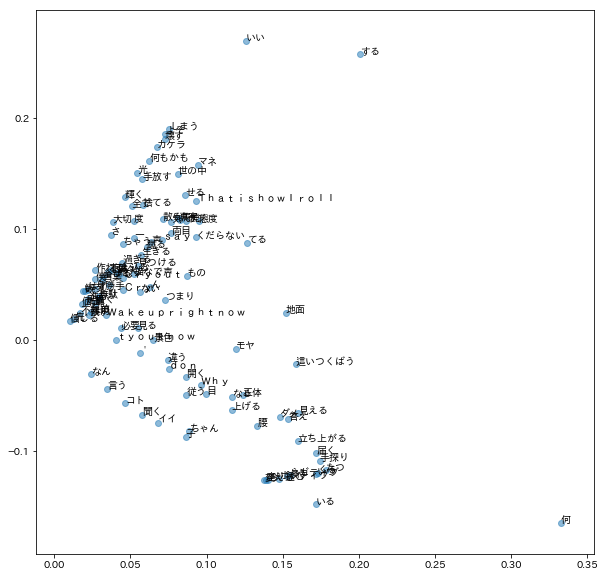

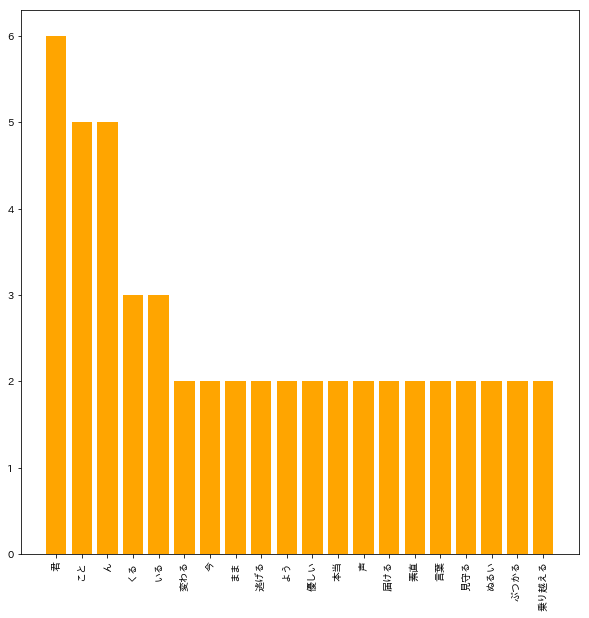

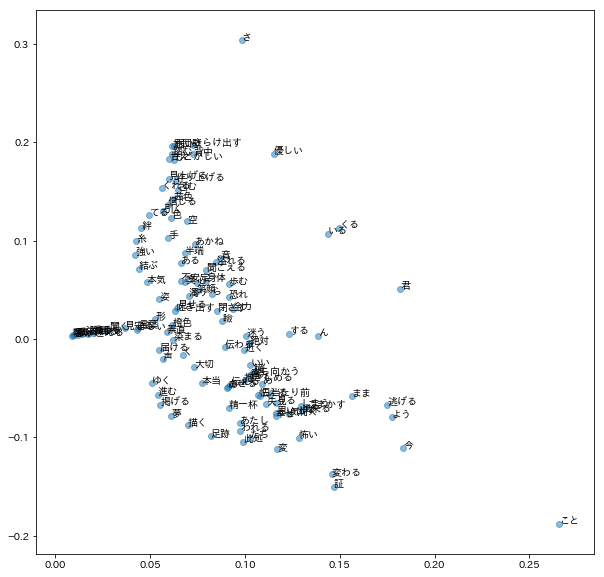

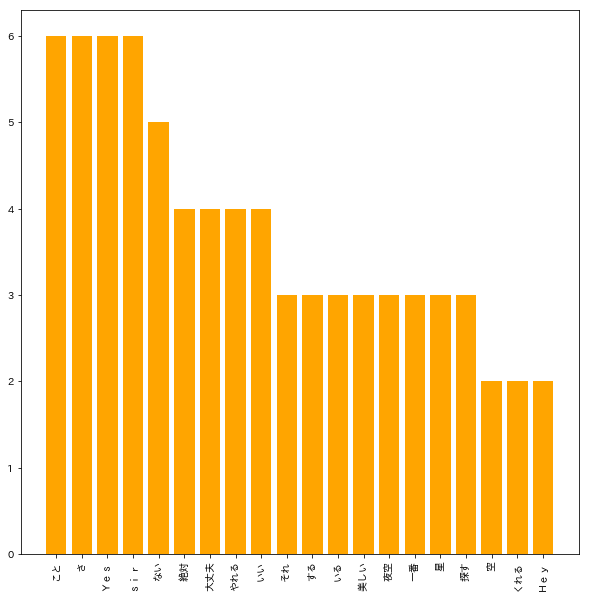

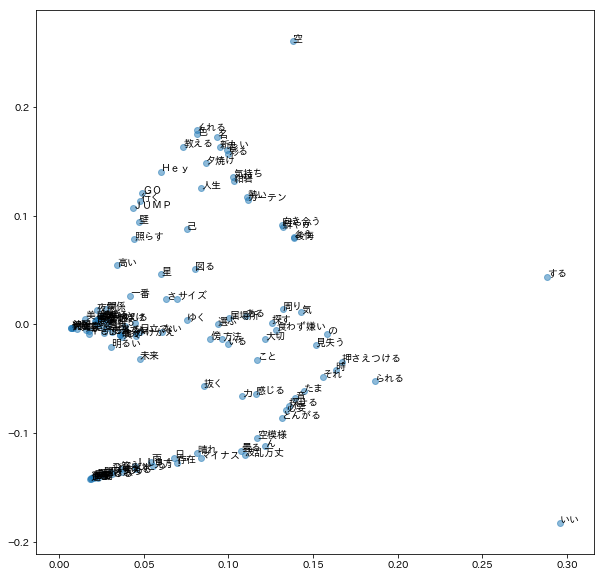

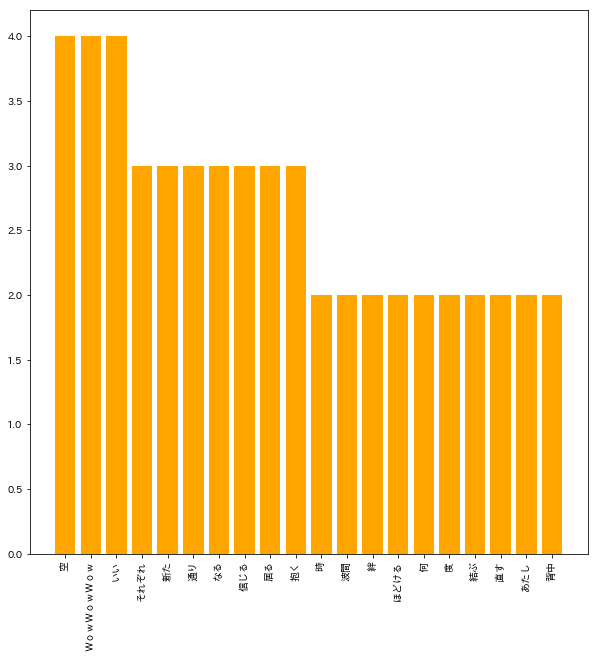

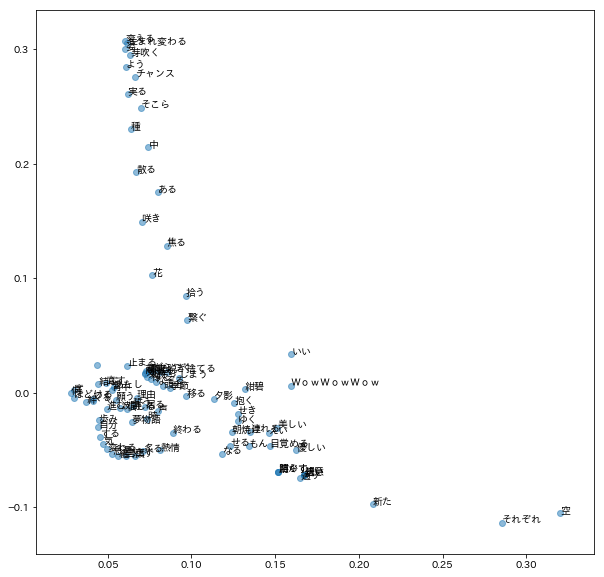

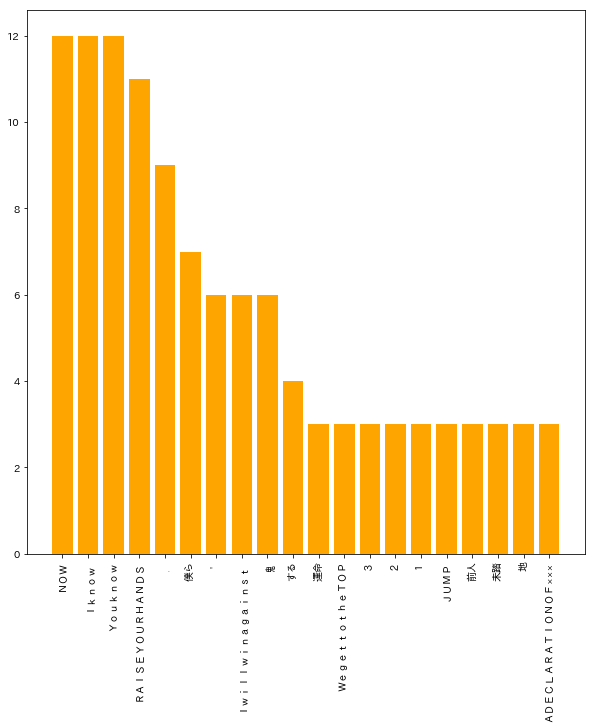

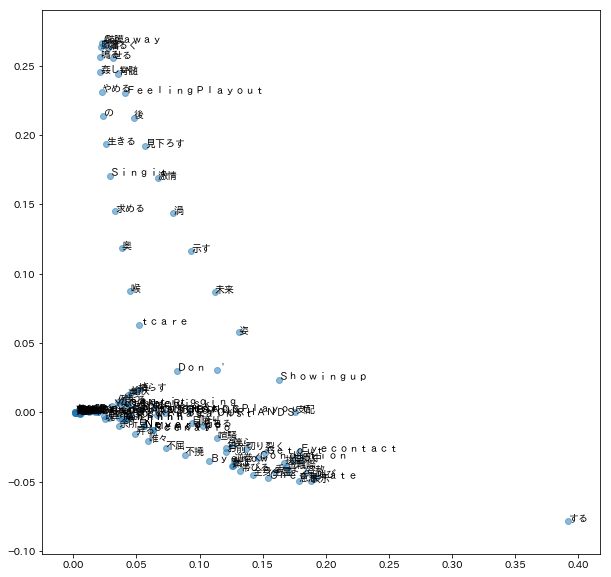

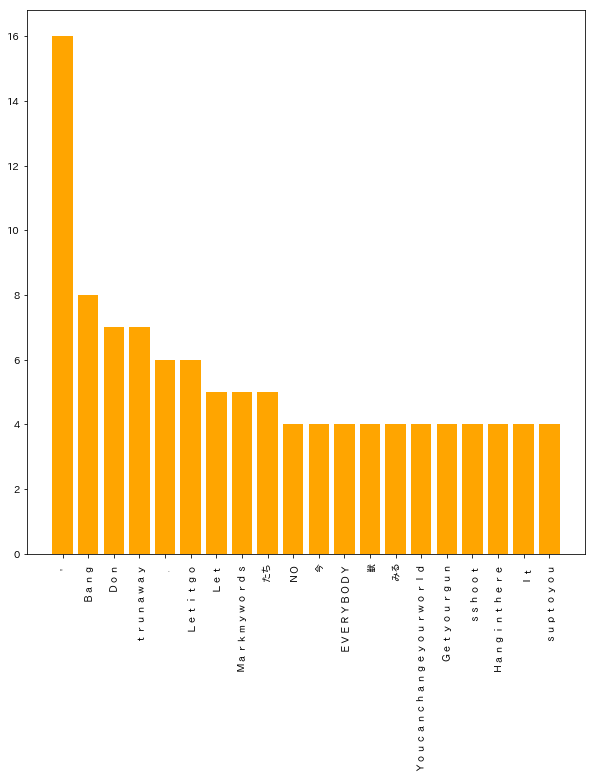

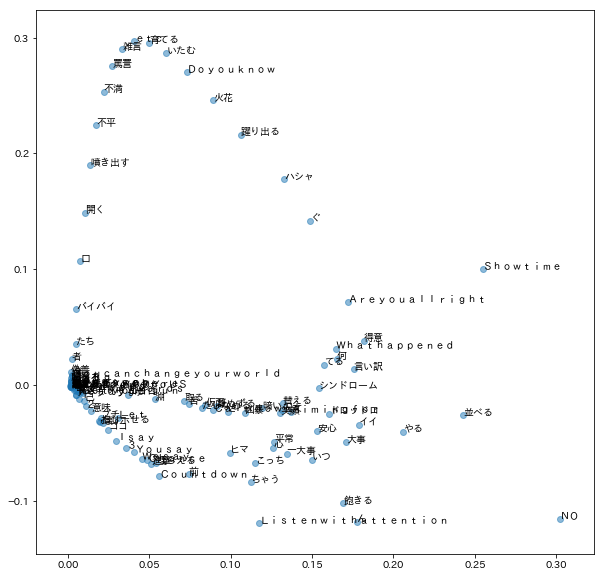

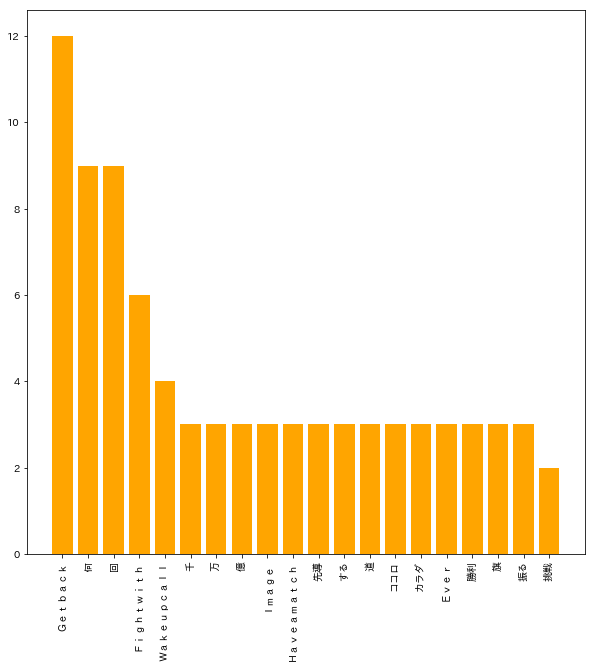

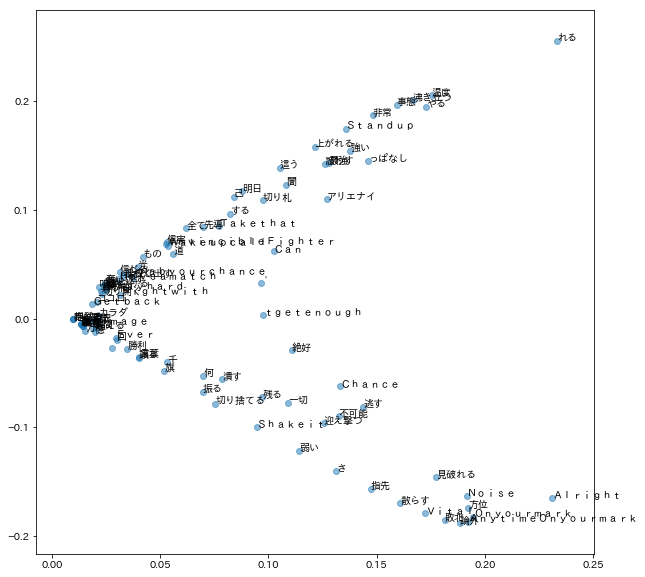

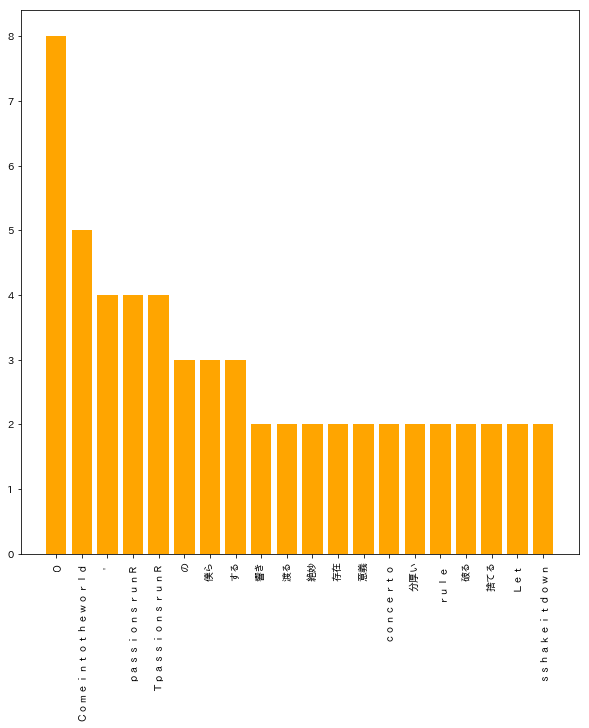

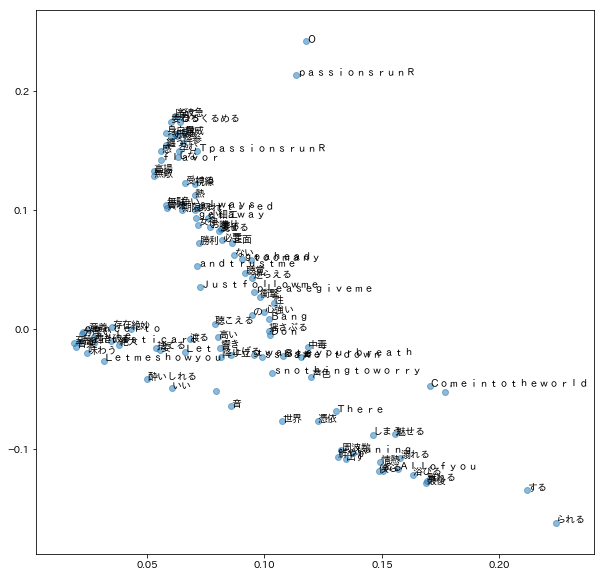

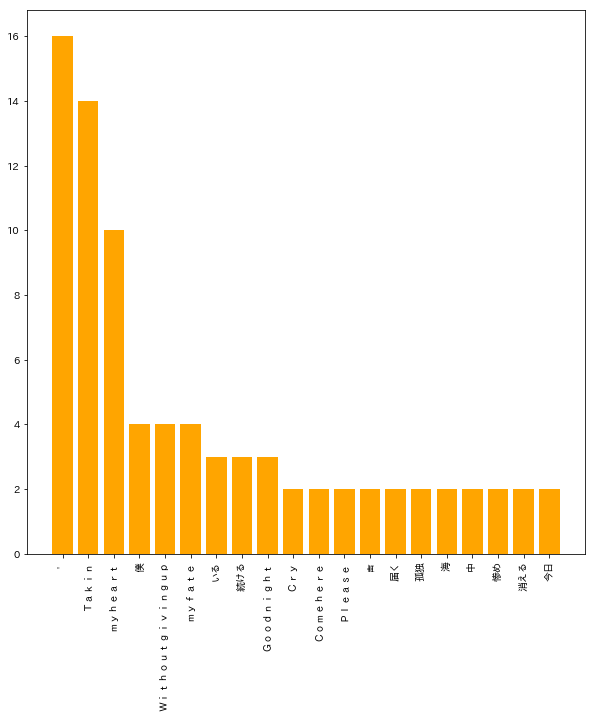

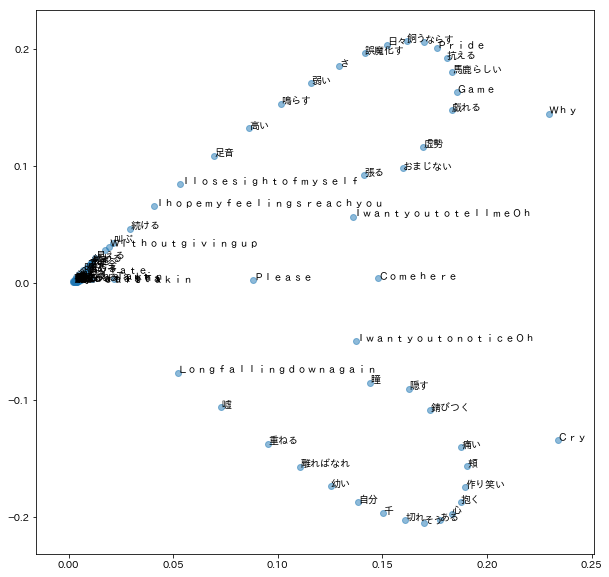

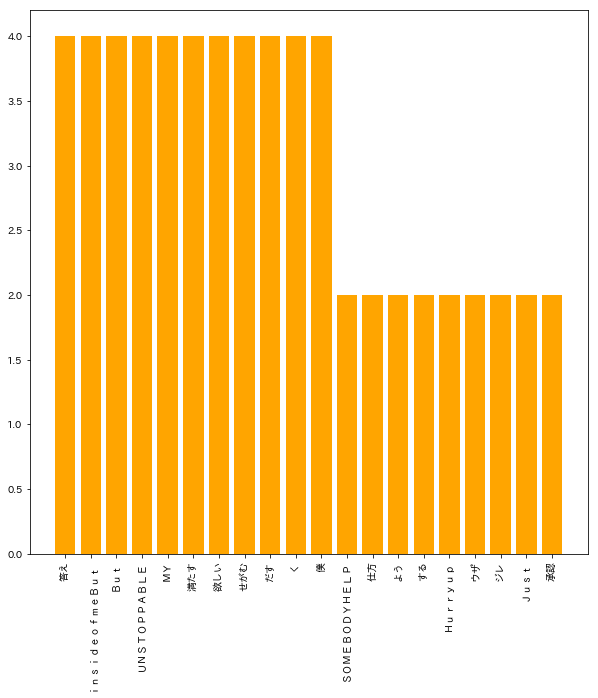

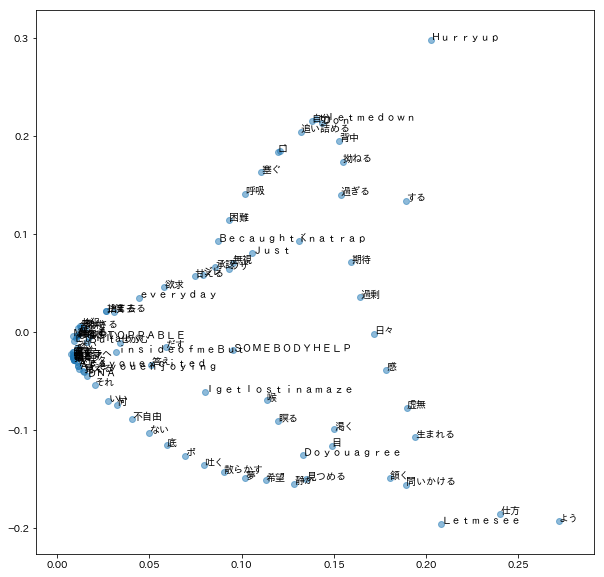

In [51]:
if __name__ =="__main__":
    
    start = time.time()
    dirlist=['Roselia','PopinParty','PastelPalettes','HelloHappyWorld','Afterglow','RAS']
    for dirname in dirlist:
        fileList=os.listdir(os.getcwd()+'\\'+str(dirname)+'\\')
        for file in fileList:
            text=read_file(dirname+'\\'+str(file))
            try:
                word_cloud(ja_tokenize(text),filename='./output\\'+file,mode=1)
                comb_words(text)
                word_network('./output\\'+file)
                word_count = Counter(ja_tokenize(text))
    #             print(word_count.most_common(20))
                display(word_count,top=20,filename='./output\\'+file)
                distribution(text,filename='./output\\'+file)
                print('finished: '+file)
            except:
                print('ERROR: '+file)
                
    print('elapsed total time: ',time.time()-start)
    #     distribution(text3,['Roselia'])
